# Final project: Stock Prediction

Given the recent stock market history, you will predict the return for ticker AAPL for the day ahead.

# Objectives

You will demonstrate your strengths in several areas, especially
- Exploratory Data Analysis
- Feature Engineering
- Creating, testing and evaluating models
- Error analysis
and Prediction **using Neural Networks**.

Your objective will be to predict next period price returns of a stock given its past prices.

**To be precise**
- given recent prices for AAPL you will predict the next *return*
- *return* will be defined precisely below
- you will be evaluated on a holdout data directory
    - it will have 2 years of data
    - you will be required to predict next period returns for the final 200 days
    - when making a prediction for date $t$, where $t$ is in the holdout data range (**beyond** the last training date)
        - you may use *actual* holdout data for dates strictlty prior to date $t$
        - That is: your prediction for date $t$ *does not* need to be dependent on your *prediction* for date $(t-1)$
    

**Predicting forward returns/prices is hard ! If you could do it well: you would be rich**

Given that fact, out of sample performance will **not** be the sole metric for your grade

This project will test your ability to analyze data, create hypotheses, test them, and improve through iteration.

**You will learn a lot, especially from failures**

This project provides a wealth of opportunity for
- Exploratory data analysis
    - This can suggest several different approaches to building one or more models
- Error Analysis
- Creating, and evaluating models iteratively, learning from past failures and successes.

So your performance will be based on your creativity and experimental process, even if the process
does not lead to great out of sample performance

# The data

As explained in the Final Project Overview:
- you will be given a data directory for training
    - supplied as a compressed archive file in the course's Resource tab in NYU Classes
    - unpacking this file will yield directory `./Data/train`

The data directory will contain one file per ticker, with a history going back many years of fields including
- Price: Close, Open, High, Low
- Volume

"return" means the percent change in the **Close** feature

You will need to
- decide which files and which fields to use
- prepare the data for training and testing
    - convert from price to return as necessary
    - prepare train and test examples:
    

## Data preparation

- The files contain prices; your goal is to predict a *return* not a price
- Your goal is to predict the **percent change of the Close feature** ("return")
- Your predicted return for day $t$ should be a function of data occuring *before* day $t$

So your first step will be to create a suitable training set.

For example, the following training set is a good starting point:
- each row is an example
- each row will have a column `Dt` indicating time $t$
- each example has *at least* 20 features
    - derived from AAPL features occuring *before* time $t$
- the target for the row with time $t$ should be the *return* of AAPL for date $t$
    - i.e., the percent price change of AAPL from time $t-1$ to time $t$



** Out of sample evaluation **

*You* should test your models out of sample.

This will be beneficial as *we* will evaluate your model out of sample using a holdout data directory.

The *holdout data directory* will be for dates that are strictly later than the latest date in the
training data directory.
- will contain 2 years of data
- you will be required to predict the latest 200 returns of AAPL for this holdout directory
- your submission *must work on the holdout directory*
    - you should assume the directory is at relative path  `./data/holdout`

So you might want to create your own validation/test data (from the training data directory) that mimics
what the holdout data directory will contain.

It is up to you to decide on the out of sample data that you use for model development.


# Suggestions for  getting started

The problem we presented to you is unstructured and not precisely defined in full detail.

- Start by defining, in detail,  the problem that you will attempt to solve
    - Do you view this as a Regression task ?  A Classification task
    - Justify your choice
~ Define the Performance Metric that you think is appropriate
    - Justify your choice

- Start with a simple model, using only data from AAPL (few features)
    - Use the model to get a feel for the problem
    - Will be a good baseline
    - Will help you form new hypotheses to test
        - may guide the choice of additional features
- Create new models iteratively
    - Train and evaluate a "simpler" model
    - Evalute performance
    - Perform error analysis
    - Propose a new "less simple" model
        - add as many features as you like, from any file in the directory

- Be disciplined in your process: avoid repeating code
    - It will be easier if you have a single piece of code that works for
        - the training directory
        - the test directory (that you might choose to create)
        - the holdout directory
    - This will
        - simplify your process
        - help ensure that your submission will work on the holdout directory !
   

# Warning: Avoid looking into the future !

Obviously, you should not use knowledge of the future to predict future prices.

But it is surprisingly easy to inadvertantly do so !  For example:
- when standardizing a data set: you might compute averages and standard deviations over the full range of dates
    - this means that the earliest dates have implicit knowledge of later dates
        - for example, suppose the mean increases after 10 days
        - the observations of the first 9 days *should not know* that the mean of the entire data range is different than what is available from earlier observations

# Evaluating your model
   
Your goals
- demonstrate that your models can predict in-sample (based on training only) somewhat successfully
    - this is easier than predicting out of sample
    - this will show that your model has "learned" something
- evaluate your model out of sample using the validation/test set you created
- run multiple experiments to try to improve out of sample prediction
- present a "final model" which we will evaluate with a holdout dataset
     - The holdut dataset will be identical in structure to the full data set we provide
     - *BUT* the dates will be strictly after the dates in the full dataset.

# Final reminder: document your thought process

**The key to getting a good grade** is to
- document everything you do
- justify the many choices you will have to make -- use data and intuition to back up your statements
- report on failed theories/experiments
    - it shows the amount of effort you expended
    - tell us
        - why you thought it was a good idea to try
        - what you learned from the failure
        - how the failure led you to try something different
        
The out of sample prediction is hard -- you may or may not do well.

What is important is to see how you tried to improve and how failure as well as success led to
better experiments.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import seaborn as sns

In [9]:
try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

if IN_COLAB:
  print("We're running Colab")

We're running Colab


In [10]:
print("Running TensorFlow version ",tf.__version__)

# Parse tensorflow version
import re

version_match = re.match("([0-9]+)\.([0-9]+)", tf.__version__)
tf_major, tf_minor = int(version_match.group(1)) , int(version_match.group(2))
print("Version {v:d}, minor {m:d}".format(v=tf_major, m=tf_minor) )

Running TensorFlow version  2.14.0
Version 2, minor 14


In [11]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [12]:
USE_COLAB_PATH = True


if IN_COLAB and USE_COLAB_PATH:
  # Mount the Google Drive at mount
  mount='/content/gdrive'
  print("Colab: mounting Google drive on ", mount)

  drive.mount(mount)
  # Set colab path
  drive_root = mount + "/MyDrive/MLFinal/stock_prediction"

  # Create drive_root if it doesn't exist
  create_drive_root = True
  if create_drive_root:
    print("\nColab: making sure ", drive_root, " exists.")
    os.makedirs(drive_root, exist_ok=True)

  # Change to the directory
  print("\nColab: Changing directory to ", drive_root)
  %cd $drive_root
else:
  print('Please run notebook on colab')



Colab: mounting Google drive on  /content/gdrive
Mounted at /content/gdrive

Colab: making sure  /content/gdrive/MyDrive/MLFinal/stock_prediction  exists.

Colab: Changing directory to  /content/gdrive/MyDrive/MLFinal/stock_prediction
/content/gdrive/MyDrive/MLFinal/stock_prediction


# Train Test split:
Since this is time series data, we have to split it chronologically, and not randomly.
I am defining a function splitData that takes the input dataframe and returns the processed datsets, split into train and test.

The test dataset will be generated from the last 200 days of the original data.

In [ ]:
DATA_DIR = "./Data"

def get_adj_close_data(tickers):
    combined_data = []

    for ticker in tickers:
        file_path = os.path.join(DATA_DIR, 'train', f'{ticker}.csv')
        df = pd.read_csv(file_path)

        # Rename 'Adj Close' and set 'Dt' as index
        df = df.rename(columns={'Adj Close': ticker}).set_index('Dt')
        df.index = pd.to_datetime(df.index)

        # Extract only the renamed 'Adj Close' column
        combined_data.append(df[[ticker]])

    # Concatenate all dataframes along the columns
    final_df = pd.concat(combined_data, axis=1)

    return final_df

In [ ]:
def splitData(data):
  start = data.index.min()
  end = data.index.max()

  test_prices = data.tail(200)
  train_prices = data.iloc[:-200]

  return train_prices, test_prices

In [ ]:
def generate_returns(train_prices, test_prices):
   y_train = train_prices["AAPL"].pct_change(1)
   y_test = test_prices["AAPL"].pct_change(1)

   return y_train, y_test

In [ ]:
def data_generate_process(tickers):
  raw_dataframe = get_adj_close_data(tickers)
  x_train, x_test = splitData(raw_dataframe)
  y_train, y_test = generate_returns(x_train, x_test)
  x_train = x_train[1:]
  x_test = x_test[1:]
  y_train = y_train[1:]
  y_test = y_test[1:]

  return raw_dataframe, x_train, x_test, y_train, y_test

In [ ]:
aapl_data = pd.read_csv("./Data/train/AAPL.csv")

In [ ]:
aapl_data

,Dt,Adj Close,Close,Div,Factor,High,Low,Open,Volume
0,2000-01-03,3.4785,111.938,0.0,1.0,112.5000,101.688,104.8750,133949200.0
1,2000-01-04,3.1852,102.500,0.0,1.0,110.6250,101.188,108.2500,128094400.0
2,2000-01-05,3.2318,104.000,0.0,1.0,110.5630,103.000,103.7500,194580400.0
3,2000-01-06,2.9521,95.000,0.0,1.0,107.0000,95.000,106.1183,191993200.0
4,2000-01-07,3.0920,99.500,0.0,1.0,101.0000,95.500,96.5000,115183600.0
...,...,...,...,...,...,...,...,...,...
4272,2016-12-23,111.3073,116.520,0.0,1.0,116.5255,115.590,115.5900,14249500.0
4273,2016-12-27,112.0142,117.260,0.0,1.0,117.8000,116.490,116.5200,18296900.0
4274,2016-12-28,111.5366,116.760,0.0,1.0,118.0170,116.200,117.5200,20905900.0
4275,2016-12-29,111.5079,116.730,0.0,1.0,117.1094,116.400,116.4500,15039500.0


## Train Test Split
I have used the functions I have written above to generate train and test data separately, and used all the tickers - it's easier for me to filter out after reading all data!

In [ ]:
# generating all tickers, and creating a dataset that we can slice and use as deemed necessary
alltickers = [x.replace(".csv","") for x in os.listdir(os.path.join(DATA_DIR,'train'))]

In [ ]:
alldata, x_train, x_test, y_train, y_test = data_generate_process(alltickers)

In [ ]:
x_train

,XLB,XLE,XLF,XLI,SPY,NVDA,XLRE,XLY,XLV,XLK,...,FB,MSFT,V,INTC,ACN,CRM,IBM,CSCO,GOOG,MA
Dt,,,,,,,,,,,,,,,,,,,,,
2000-01-04,16.3244,17.6156,9.2098,19.5101,96.5415,3.4992,NaN,22.8930,22.3390,41.4171,...,NaN,36.3524,NaN,26.7056,NaN,NaN,73.8175,39.7701,NaN,NaN
2000-01-05,16.9988,18.0803,9.1375,19.4232,96.7142,3.3840,NaN,22.6114,22.1386,40.8022,...,NaN,36.7357,NaN,26.9270,NaN,NaN,76.4112,39.6482,NaN,NaN
2000-01-06,17.4352,18.7773,9.5388,19.6840,95.1599,3.1632,NaN,22.8685,22.2093,39.4496,...,NaN,35.5051,NaN,25.3572,NaN,NaN,75.0938,38.9903,NaN,NaN
2000-01-07,17.4253,18.9780,9.6966,20.4340,100.6864,3.2160,NaN,23.9458,22.4804,40.1382,...,NaN,35.9691,NaN,26.4037,NaN,NaN,74.7644,41.2810,NaN,NaN
2000-01-10,17.3658,18.8196,9.5256,20.4340,101.0318,3.3216,NaN,23.8234,24.7792,41.6631,...,NaN,36.2313,NaN,27.6112,NaN,NaN,77.7287,42.8162,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-03-11,41.2645,55.6674,13.1015,50.0959,188.4534,31.7160,27.1018,73.3142,64.6712,40.4615,...,109.41,49.4602,69.9297,28.7060,98.4968,71.63,120.5945,24.7261,726.82,86.4432
2016-03-14,40.9857,55.3014,13.0608,50.1422,188.2117,31.7948,27.1896,73.5892,64.3978,40.5086,...,109.89,49.5534,69.7931,28.4077,99.0933,72.22,120.9503,24.5841,730.49,86.7262
2016-03-15,41.0787,55.1942,13.0549,50.1144,187.9050,31.6373,27.3694,73.5703,63.3984,40.6597,...,110.67,49.9448,70.2031,28.6065,99.7924,71.70,121.1027,24.5486,728.33,87.2044


In [ ]:
x_train.columns

Index(['XLB', 'XLE', 'XLF', 'XLI', 'SPY', 'NVDA', 'XLRE', 'XLY', 'XLV', 'XLK',
       'XLP', 'ADBE', 'XLU', 'AAPL', 'FB', 'MSFT', 'V', 'INTC', 'ACN', 'CRM',
       'IBM', 'CSCO', 'GOOG', 'MA'],
      dtype='object')

In [ ]:
y_train

Dt
2000-01-04   -0.084318
2000-01-05    0.014630
2000-01-06   -0.086546
2000-01-07    0.047390
2000-01-10   -0.017594
                ...   
2016-03-11    0.010774
2016-03-14    0.002543
2016-03-15    0.020093
2016-03-16    0.013292
2016-03-17   -0.001604
Name: AAPL, Length: 4076, dtype: float64

In [ ]:
x_test

,XLB,XLE,XLF,XLI,SPY,NVDA,XLRE,XLY,XLV,XLK,...,FB,MSFT,V,INTC,ACN,CRM,IBM,CSCO,GOOG,MA
Dt,,,,,,,,,,,,,,,,,,,,,
2016-03-21,42.5549,56.8829,13.2767,52.1419,191.2097,33.3796,27.7330,74.4064,63.6163,41.4913,...,111.85,50.1965,72.0189,29.2302,100.8083,72.25,125.9059,25.0190,742.09,90.1223
2016-03-22,42.0699,56.5683,13.2358,51.8438,191.1070,33.3205,27.6842,74.2826,64.2503,41.5008,...,112.25,50.3922,71.2282,29.2121,100.5007,72.85,125.4569,25.0989,740.75,89.5465
2016-03-23,41.5477,55.3276,13.1363,51.5083,189.8458,33.8914,27.5824,73.7588,63.7961,41.2636,...,112.54,50.2990,72.1556,28.9229,100.3423,71.78,123.1697,24.6995,738.06,89.9076
2016-03-24,41.5477,55.5973,13.0544,51.3592,189.7617,33.9407,27.6267,73.8540,63.7677,41.3774,...,113.05,50.5227,72.3801,28.8144,106.5309,72.44,125.3298,24.8149,735.30,89.6929
2016-03-28,41.7249,55.3006,13.0953,51.3779,189.8738,34.2852,27.8038,74.1873,63.5880,41.2731,...,113.69,49.8983,72.3216,28.8325,106.4098,71.95,125.7110,24.7616,733.53,89.0390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,47.6722,69.8796,22.4294,59.7018,214.2890,108.7056,27.7296,79.5679,66.5372,47.0785,...,117.27,60.1241,76.7238,34.2162,111.7080,69.87,146.5132,27.8207,789.91,102.8042
2016-12-27,47.9283,70.0352,22.4579,59.8250,214.8206,116.1718,27.8028,79.8767,66.6713,47.2708,...,118.01,60.1621,76.9202,34.3088,111.7746,69.85,146.8911,27.9574,791.55,102.8926
2016-12-28,47.4446,69.2756,22.2296,59.1994,213.0452,108.1808,27.5925,79.3267,66.1636,46.8478,...,116.92,59.8864,76.8711,33.9015,110.8808,69.09,146.0562,27.7205,785.05,101.7930


In [ ]:
y_test

Dt
2016-03-21   -0.000094
2016-03-22    0.007649
2016-03-23   -0.005529
2016-03-24   -0.004334
2016-03-28   -0.004543
                ...   
2016-12-23    0.001978
2016-12-27    0.006351
2016-12-28   -0.004264
2016-12-29   -0.000257
2016-12-30   -0.007796
Name: AAPL, Length: 199, dtype: float64

# Exploratory Data Analysis
Before we begin building our models, even for creating the right baseline model, let's first perform some EDA.

- Plotting AAPL price movements
- Plotting AAPL returns
- Plotting SPY returns overlay on AAPL
- Plotting heatmap of all stocks mentioned to find the best features

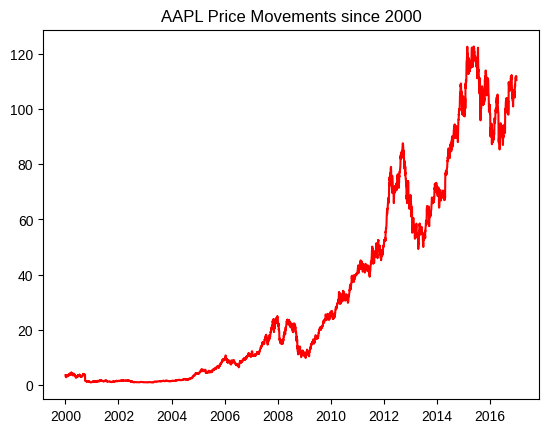

In [ ]:
plt.plot(alldata["AAPL"], color = 'red')
plt.title("AAPL Price Movements since 2000")
plt.style.use("seaborn-v0_8-whitegrid")

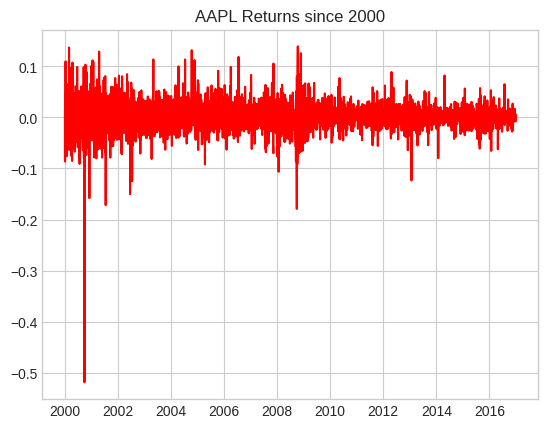

In [ ]:
plt.plot(alldata["AAPL"].pct_change(1), color = 'red')
plt.title("AAPL Returns since 2000")
plt.style.use("seaborn-v0_8-whitegrid")

In [ ]:
datawithsp = get_adj_close_data(["AAPL","SPY"])

In [ ]:
datawithsp_ret = (datawithsp.pct_change(1))[1:]

In [ ]:
datawithsp_ret

,AAPL,SPY
Dt,,
2000-01-04,-0.084318,-0.039106
2000-01-05,0.014630,0.001789
2000-01-06,-0.086546,-0.016071
2000-01-07,0.047390,0.058076
2000-01-10,-0.017594,0.003430
...,...,...
2016-12-23,0.001978,0.001464
2016-12-27,0.006351,0.002481
2016-12-28,-0.004264,-0.008265


In [ ]:
datawithsp

,AAPL,SPY
Dt,,
2000-01-03,3.4785,100.4705
2000-01-04,3.1852,96.5415
2000-01-05,3.2318,96.7142
2000-01-06,2.9521,95.1599
2000-01-07,3.0920,100.6864
...,...,...
2016-12-23,111.3073,214.2890
2016-12-27,112.0142,214.8206
2016-12-28,111.5366,213.0452


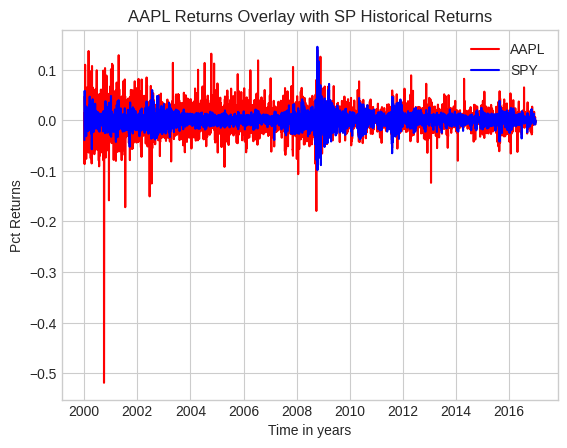

In [ ]:
plt.plot(datawithsp_ret["AAPL"], label = "AAPL", color = 'red')
plt.plot(datawithsp_ret["SPY"], label = "SPY", color = 'blue')
plt.title("AAPL Returns Overlay with SP Historical Returns")
plt.style.use("seaborn-v0_8-whitegrid")
plt.xlabel("Time in years")
plt.ylabel("Pct Returns")
plt.legend()

We see that the AAPL returns more or less closely track the SP returns. There are a few massive outliers, however, like close to 2001. This coincides with AAPL's earnings warning for the last fiscal quarter of 2000. [1]

In [ ]:
corr_df = alldata.corr(method='pearson')

<Axes: >

<Figure size 640x480 with 0 Axes>

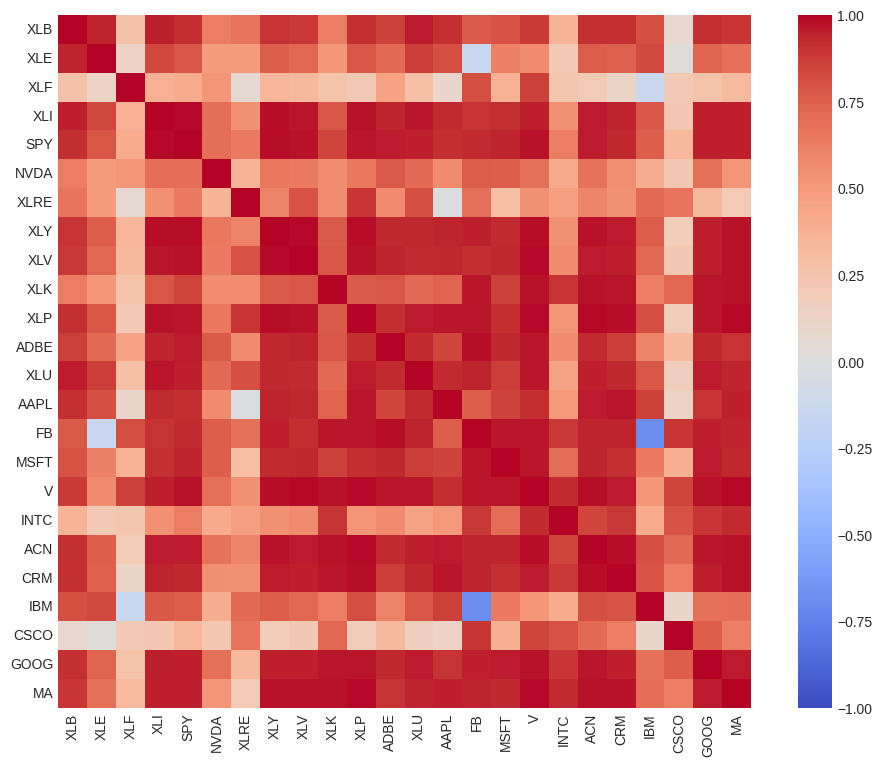

In [ ]:
plt.figure() #initialize the figure
f, ax = plt.subplots(figsize=(12, 9)) 	# set up the matplotlib figure
sns.heatmap(corr_df, vmax=1.0, vmin=-1.0, square=True, cmap = "coolwarm") 	# draw the heatmap using seaborn

References:
[1] https://www.thestreet.com/apple/stock/apple-stock-down-52-when-and-why-it-happened
[2] https://www.ssga.com/us/en/intermediary/etfs/funds/the-consumer-staples-select-sector-spdr-fund-xlp
[3]

In [ ]:
# a more intuitive representation will be to plot AAPL's correlation values with the other stocks and indices mentioned
aapl_corr = corr_df["AAPL"].drop("AAPL")
max_corr = aapl_corr.max()

In [ ]:
aapl_corr

XLB     0.906980
XLE     0.809303
XLF     0.099802
XLI     0.929599
SPY     0.919254
NVDA    0.568540
XLRE   -0.008796
XLY     0.940181
XLV     0.936299
XLK     0.734564
XLP     0.964700
ADBE    0.850899
XLU     0.925246
FB      0.760280
MSFT    0.857842
V       0.914697
INTC    0.493610
ACN     0.955996
CRM     0.962061
IBM     0.862938
CSCO    0.128878
GOOG    0.900443
MA      0.948031
Name: AAPL, dtype: float64

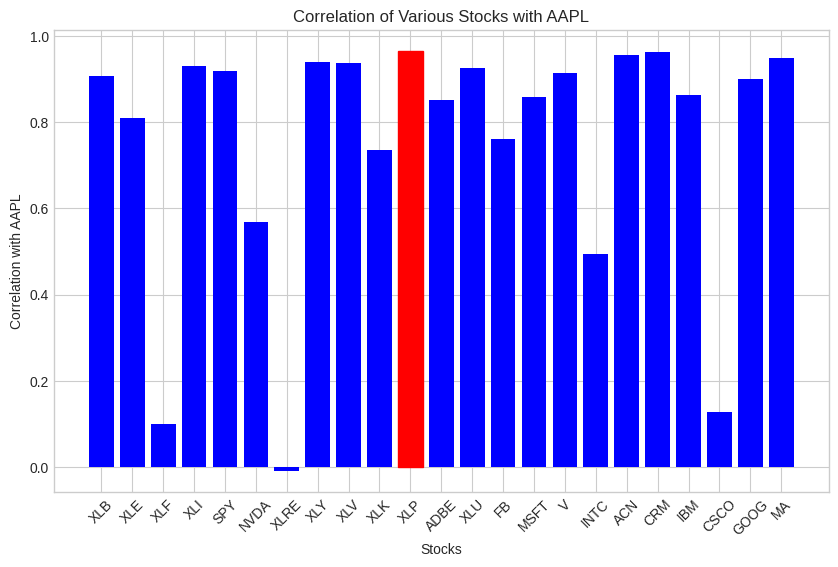

In [ ]:
max_corr_ticker = aapl_corr.idxmax()

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(aapl_corr.index, aapl_corr.values, color='blue')

# Highlight the bar with the maximum value
max_corr_bar_index = list(aapl_corr.index).index(max_corr_ticker)
bars[max_corr_bar_index].set_color('red')

plt.xlabel('Stocks')
plt.ylabel('Correlation with AAPL')
plt.title('Correlation of Various Stocks with AAPL')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

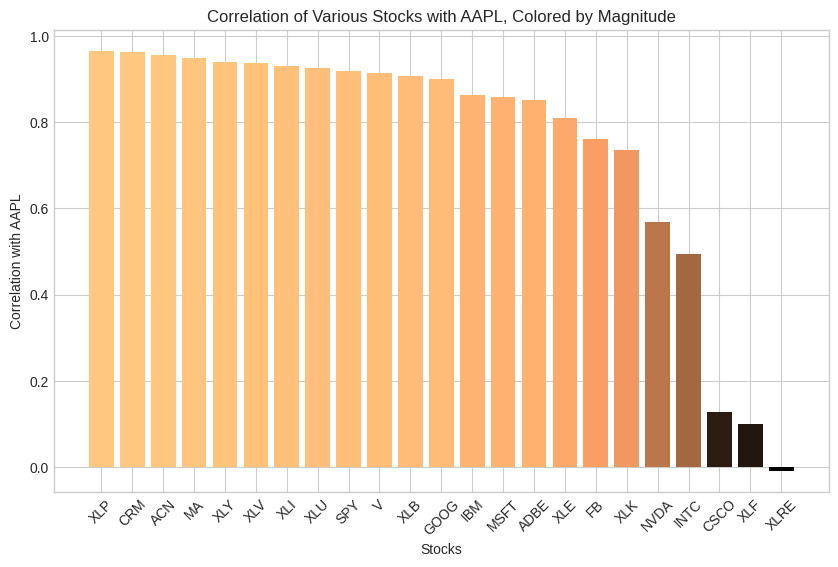

In [ ]:
sorted_aapl_corr = aapl_corr.sort_values(ascending=False)

# Generate a range of color intensities
norm = plt.Normalize(sorted_aapl_corr.values.min(), sorted_aapl_corr.values.max())
colors = plt.cm.copper(norm(sorted_aapl_corr.values))

# Create a bar plot with descending colors
plt.figure(figsize=(10, 6))
plt.bar(sorted_aapl_corr.index, sorted_aapl_corr.values, color=colors)

# Add labels and title
plt.xlabel('Stocks')
plt.ylabel('Correlation with AAPL')
plt.title('Correlation of Various Stocks with AAPL, Colored by Magnitude')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# Show the plot
plt.show()

The above graph gives a much more actionable insight on the stocks that we can use to predict AAPL returns. We see that XLP has the highest Pearson correlation. This is the Consumer Staples Select Sector Fund, comprising of consumer stocks [2].
We can utilise the top correlated values in our regression models that we will build later on.

Now that we've found utilizable related stocks, let us examine the values of the adj close prices of these stocks. I am specifically looking for columns with high number of missing values or low correlation from the above analysis so we can drop them.

I am taking the top 15 most correlated stocks with AAPL to build the model.

In [ ]:
# checking "alldata" for null values
alldata15 = alldata[sorted_aapl_corr.index[:15]]

In [ ]:
alldata15.columns

Index(['XLP', 'CRM', 'ACN', 'MA', 'XLY', 'XLV', 'XLI', 'XLU', 'SPY', 'V',
       'XLB', 'GOOG', 'IBM', 'MSFT', 'ADBE'],
      dtype='object')

In [ ]:
# now I will check these 15 for null values, and I will remove columns that have high number of null values, since imputing might not lead to accurate results here
alldata15.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4277 entries, 2000-01-03 to 2016-12-30
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   XLP     4277 non-null   float64
 1   CRM     3155 non-null   float64
 2   ACN     3888 non-null   float64
 3   MA      2670 non-null   float64
 4   XLY     4277 non-null   float64
 5   XLV     4277 non-null   float64
 6   XLI     4277 non-null   float64
 7   XLU     4277 non-null   float64
 8   SPY     4277 non-null   float64
 9   V       2214 non-null   float64
 10  XLB     4277 non-null   float64
 11  GOOG    3115 non-null   float64
 12  IBM     4277 non-null   float64
 13  MSFT    4277 non-null   float64
 14  ADBE    4277 non-null   float64
dtypes: float64(15)
memory usage: 534.6 KB


The column V has about 50% missing values - I will therefore remove it.
I am not removing other columns, but I will prefer using columns where imputing will be less used.

In [ ]:
alldata15 = alldata15.drop("V", axis = 1)

In [ ]:
alldata15.columns

Index(['XLP', 'CRM', 'ACN', 'MA', 'XLY', 'XLV', 'XLI', 'XLU', 'SPY', 'XLB',
       'GOOG', 'IBM', 'MSFT', 'ADBE'],
      dtype='object')

# Baseline Model Construction
Based on the above experimentation, I am going to try building two baseline models:
one is a basic forecasting model using time series and another one is a regression model.


**Augmented Dickey Fuller Test**

- First I have performed Augmented Dickey Fuller test to check for stationarity of the data.


Null Hypothesis: Time series is non-staionary.
Alternate Hypothesis: Time series is stationary.

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(alldata["AAPL"].values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.414737
p-value: 0.982038
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567



---

### Analysis of Time Series Data Using Augmented Dickey-Fuller (ADF) Test

The Augmented Dickey-Fuller (ADF) test was applied to the given time series data to examine the presence of unit roots, indicating non-stationarity. The results of the test are as follows:

- **ADF Statistic:** 0.414737
- **p-value:** 0.982038
- **Critical Values:**
  - 1%: -3.432
  - 5%: -2.862
  - 10%: -2.567

#### Interpretation:

1. **ADF Statistic:** The ADF statistic is positive and significantly higher than the critical values at the 1%, 5%, and 10% levels. In the context of the ADF test, a lower (more negative) statistic is indicative of stationarity. The positive value here suggests the opposite, implying non-stationarity in the time series.

2. **p-value:** The high p-value, nearing 1, indicates a strong inability to reject the null hypothesis of the ADF test, which posits that the series has a unit root and is, therefore, non-stationary. This further substantiates the likelihood of non-stationarity in the data.

3. **Critical Values:** These values provide thresholds for the ADF statistic at various confidence levels. The fact that the ADF statistic does not fall below any of these thresholds reinforces the conclusion that the null hypothesis cannot be rejected.

#### Conclusion:

The results strongly suggest that the time series in question is non-stationary. This characteristic implies potential complications due to trends, seasonality, or varying variance over time, which must be considered in any subsequent modeling and forecasting efforts. It is recommended to either transform the series to achieve stationarity (e.g., through differencing or logarithmic transformation) or to employ models specifically designed to handle non-stationary data, such as ARIMA with appropriate differencing or trend components. I therefore cannot utilise a direct time-series method as a baseline.

---


# **BASELINE 1**

---

### Baseline Prediction Model for Stock Returns Using Historical Mean

#### Objective:

Develop a baseline prediction model for forecasting future stock returns. The model utilizes a simple yet effective approach by leveraging the mean of past returns over a specified time horizon as the predictor for future returns.

#### Methodology:

- **Time Horizon (\( t_h \))**: This refers to the period over which past returns are analyzed to predict future returns. For instance, if \( t_h = 40 \) days, the model calculates the average return of these 40 days.

- **Mean Return Calculation**: The mean return from day \( t-t_h \) to day \( t \) is computed. This average represents the expected return for future days (\( t+x \)), where \( x \) is any number of days ahead of \( t \).

- **Prediction Model**: The model posits that the mean return of the specified time window (\( t_h \)) is a stable and representative estimate for short-term future returns. This approach assumes that the stock's future behavior will be similar to its recent past.

#### Implementation:

1. **Data Preparation**: The model requires daily adjusted closing prices of the stock (e.g., AAPL). A percentage return is calculated for each day.

2. **Return Calculation**: The daily returns are used to calculate the mean return over the specified time horizon (\( t_h \)).

3. **Forecasting**: This mean return is then used as the predicted return for subsequent days.

#### Applications and Limitations:

- **Baseline Model**: This model serves as a baseline for more complex predictive models. Its simplicity allows for easy implementation and understanding, making it a good starting point for further analytical enhancements.

- **Temporal Consistency**: The approach assumes temporal consistency in stock returns, implying that recent past returns are good indicators of immediate future returns.

- **Limitations**: The model does not account for external factors like market volatility, economic changes, or company-specific news that can significantly impact stock prices. It also assumes that historical patterns will repeat in the short term, which might not always hold true.

- **Sensitivity to Time Horizon**: The choice of \( t_h \) is crucial. Different time horizons may yield different predictions, and there is no one-size-fits-all choice for this parameter. It requires empirical tuning based on the specific stock and market conditions.

#### Conclusion:

This baseline model offers a straightforward approach to predicting stock returns using historical data. While it provides a useful starting point, it is essential to combine it with more sophisticated models and incorporate broader market analysis for more accurate and comprehensive forecasting.

---



In [ ]:
from sklearn.metrics import mean_squared_error

# please recollent that I had created a dataset "aapl_data" for all of the data contained in "AAPL.csv".
# I will be using that data since we need a rolling average and not test and train splits.

def rolling_mean_baseline(aapl_data, horizon):
  baseline = pd.DataFrame()


  baseline['returns'] = aapl_data['Adj Close'].pct_change()
  baseline['pred'] = baseline['returns'].rolling(horizon).mean().shift(1)
  # Plot returns and predictions
  %matplotlib inline
  %config InlineBackend.figure_format = 'retina'
  plt.style.use('seaborn')

  plt.figure(figsize=(10,6))
  plt.grid(True)
  plt.xlabel('Date')
  plt.ylabel('Return')
  plt.plot(baseline['returns'])
  plt.plot(baseline['pred'])

  plt.legend(["returns", "prediction"], loc ="lower right")

  plt.title('AAPL returns')
  plt.show()

  # Assuming df_scaled is your DataFrame
  total_length = len(aapl_data)
  split_index = total_length - 200  # Index for the last 200 days

  y_test = baseline.dropna()['returns']
  y_pred = baseline.dropna()['pred']

  # Splitting the data into training and testing sets
  # y_train: training data, and y_train_test means the actual data, whereas y_train_pred is the predicted version of the training data
  y_train_test = y_test[:split_index]
  y_train_pred = y_pred[:split_index]
  # y_test: is the set of testing data, and y_test_test is the actual testing data, whereas y_test_pred is the predicted version of the testing data
  y_test_test = y_test[split_index:]
  y_test_pred = y_pred[split_index:]

  # Compute the RMSE for the training set
  train_rms = np.sqrt(mean_squared_error(y_train_test, y_train_pred))
  print("Train RMSE:", train_rms)

  # Compute the RMSE for the test set (last 200 days)
  test_rms = np.sqrt(mean_squared_error(y_test_test, y_test_pred))
  print("Test RMSE (Last 200 days):", test_rms)

  return baseline

<ipython-input-38-112a7b25436b>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


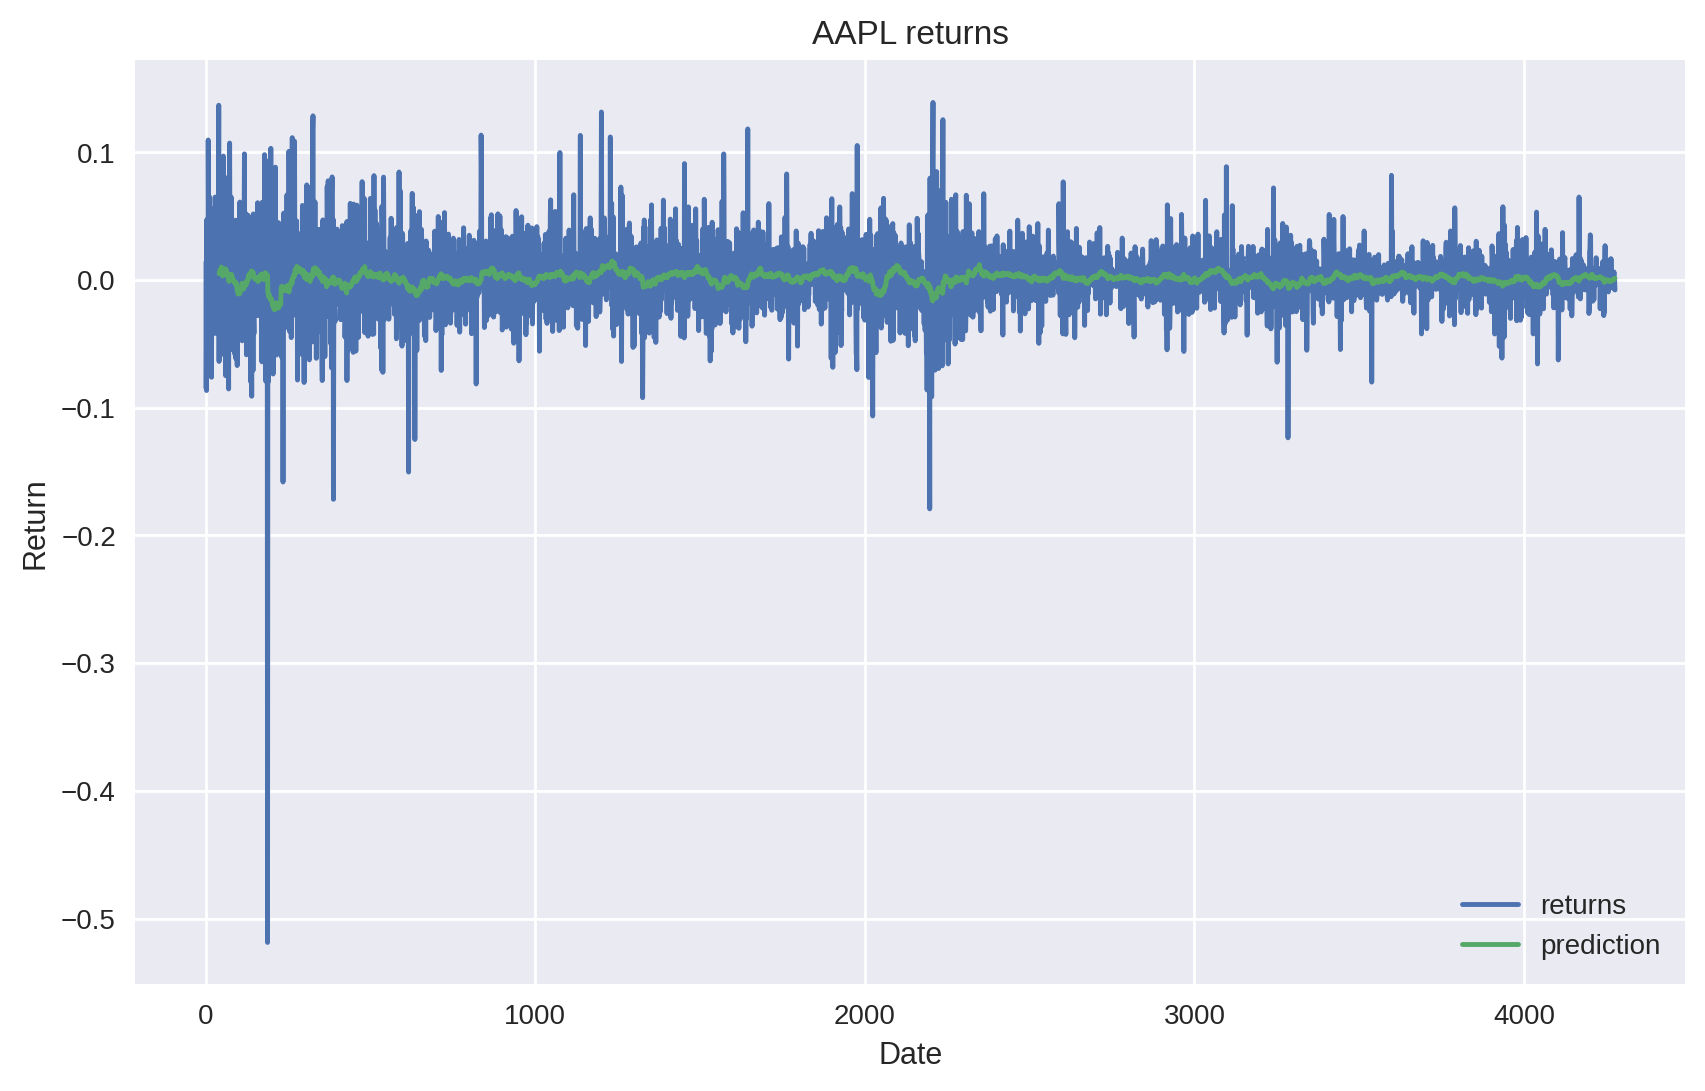

Train RMSE: 0.0271794158661905
Test RMSE (Last 200 days): 0.012160323410029124


In [ ]:
baseline1 = rolling_mean_baseline(aapl_data, 40)

### **AAPL Returns and Predictions**
 *Figure 1: AAPL Returns vs. Rolling Mean Predictions*

The above graph illustrates the actual returns (blue line) of AAPL stock against the rolling mean predictions (green line) using a 40-day horizon. The proximity of the prediction line to the actual returns indicates the model's general performance in capturing the trend of stock movements over the specified period. Notably, the training RMSE is 0.0271794158661905, which translates to 2.7179% when expressed as a percentage. This value is higher than the test RMSE, which is 0.012160323410029124, or 1.2160% in percentage terms.

A higher training RMSE suggests that the model encountered more variability or noise in the training dataset compared to the test set. This could be due to several factors, including increased market volatility or economic events affecting the stock price in the training period. Conversely, the lower RMSE on the test dataset indicates that the returns during the last 200 days were more consistent and predictable by the rolling mean method. It is crucial to assess whether this performance is due to the model capturing genuine patterns or if the test period characteristics anomalously favor the model's simplicity.


# **BASELINE 2: Regression**
I am using regression to predict the future prices, and from there I will calculate the returns and use that as the second baseline.

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
baseline2 = pd.DataFrame()
baseline2['returns'] = aapl_data['Adj Close'].pct_change()
baseline2['prices'] = aapl_data['Adj Close']
baseline2 = baseline2.dropna()

In [ ]:
baseline2

,returns,prices
1,-0.084318,3.1852
2,0.014630,3.2318
3,-0.086546,2.9521
4,0.047390,3.0920
5,-0.017594,3.0376
...,...,...
4272,0.001978,111.3073
4273,0.006351,112.0142
4274,-0.004264,111.5366
4275,-0.000257,111.5079


In [ ]:
train_df = pd.DataFrame()
test_df = pd.DataFrame()
train_df = baseline2[:-200]
test_df = baseline2[-200:]

In [ ]:
train_df

,returns,prices
1,-0.084318,3.1852
2,0.014630,3.2318
3,-0.086546,2.9521
4,0.047390,3.0920
5,-0.017594,3.0376
...,...,...
4072,0.010774,96.0777
4073,0.002543,96.3220
4074,0.020093,98.2574
4075,0.013292,99.5634


In [ ]:
# just a check!
len(train_df)+len(test_df) == len(baseline2)

True

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree = 2, include_bias = False)
poly_features = poly.fit_transform(np.array(range(0,train_df.shape[0])).reshape(-1,1))

In [ ]:
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, train_df['prices'])
train_pred = poly_reg_model.predict(poly.transform(np.array(range(0,train_df.shape[0])).reshape(-1,1)))

<ipython-input-47-1907d3045cd3>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


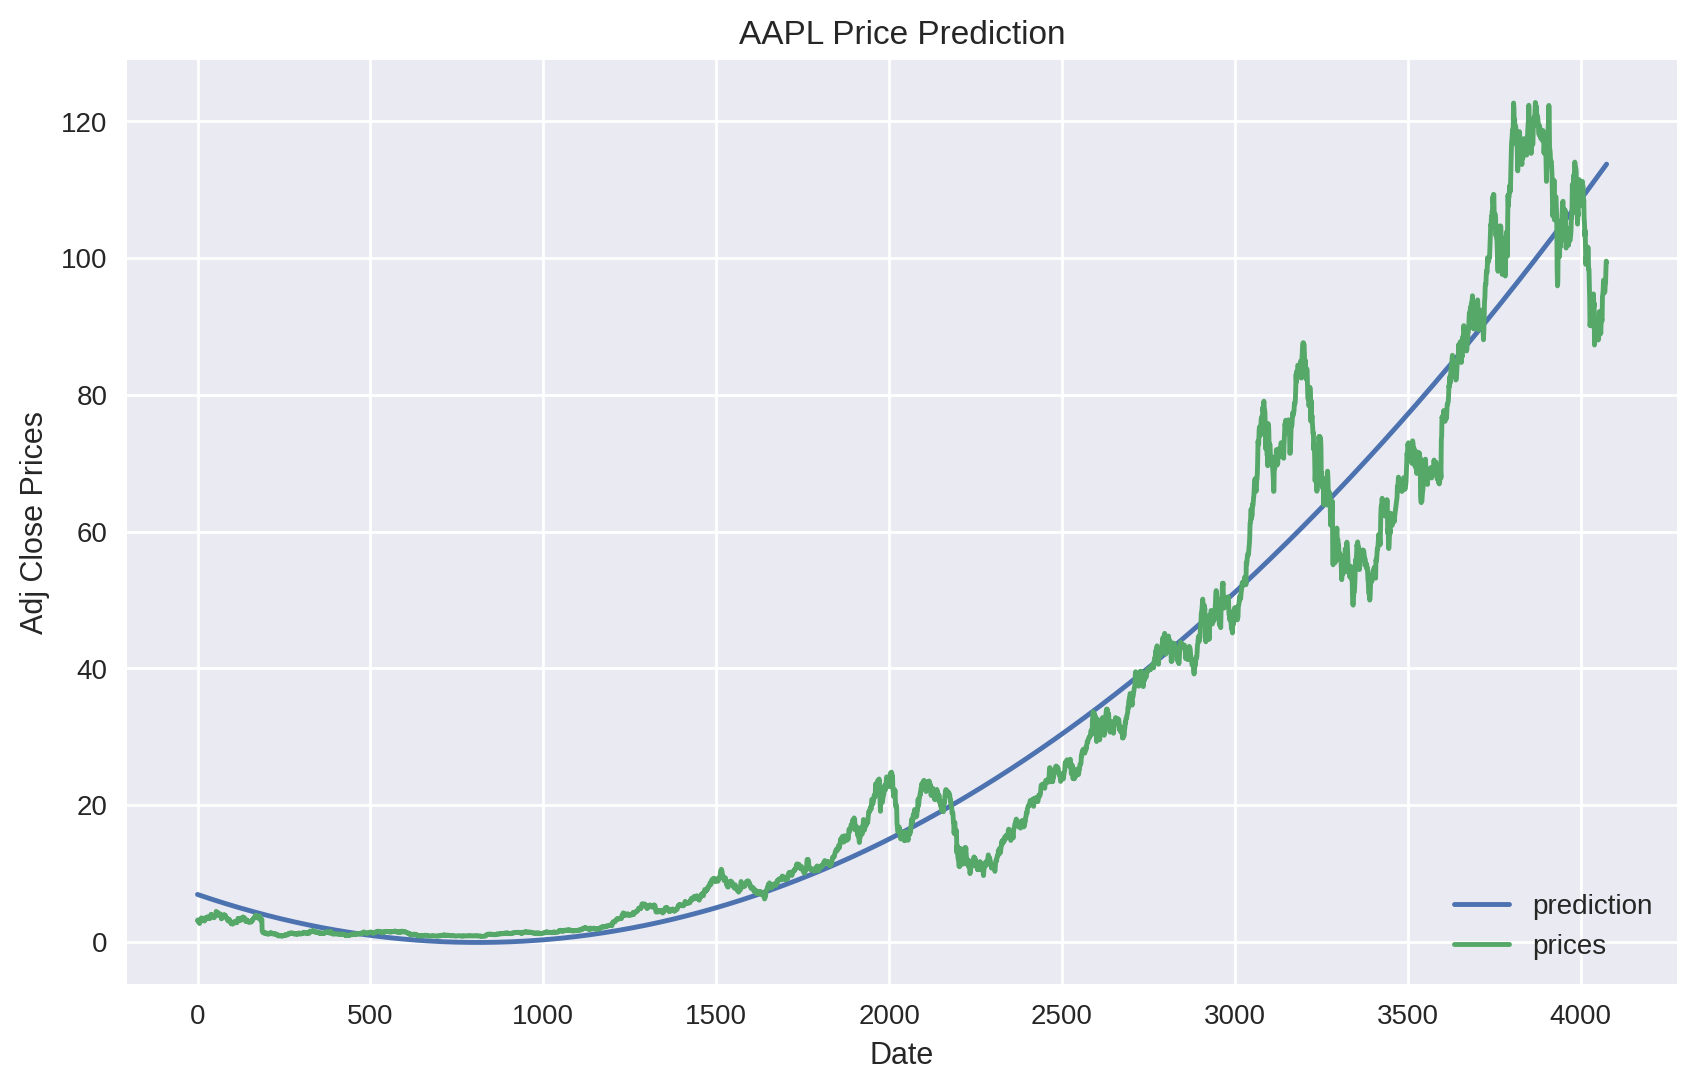

In [ ]:
# Plot returns and predictions
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Adj Close Prices')
plt.plot(train_pred)
plt.plot(train_df['prices'].values)

plt.legend(["prediction",'prices'], loc ="lower right")

plt.title('AAPL Price Prediction')
plt.show()

Now let's calculate the returns and plot the returns graph for the predicted values.

In [ ]:
pred = poly_reg_model.predict(poly.transform(np.array(range(train_df.shape[0],train_df.shape[0]+200)).reshape(-1,1)))

In [ ]:
test_df

,returns,prices
4077,0.001134,99.5164
4078,-0.000094,99.5070
4079,0.007649,100.2681
4080,-0.005529,99.7137
4081,-0.004334,99.2815
...,...,...
4272,0.001978,111.3073
4273,0.006351,112.0142
4274,-0.004264,111.5366
4275,-0.000257,111.5079


In [ ]:
test_df['pred_close'] = pred

<ipython-input-50-75e5b60de1c0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred_close'] = pred


In [ ]:
test_df['pred_ret'] = test_df['pred_close'].pct_change()

<ipython-input-51-344eb77c3b7b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred_ret'] = test_df['pred_close'].pct_change()


In [ ]:
test_df = test_df.dropna()

<ipython-input-53-ff40ded77f8f>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


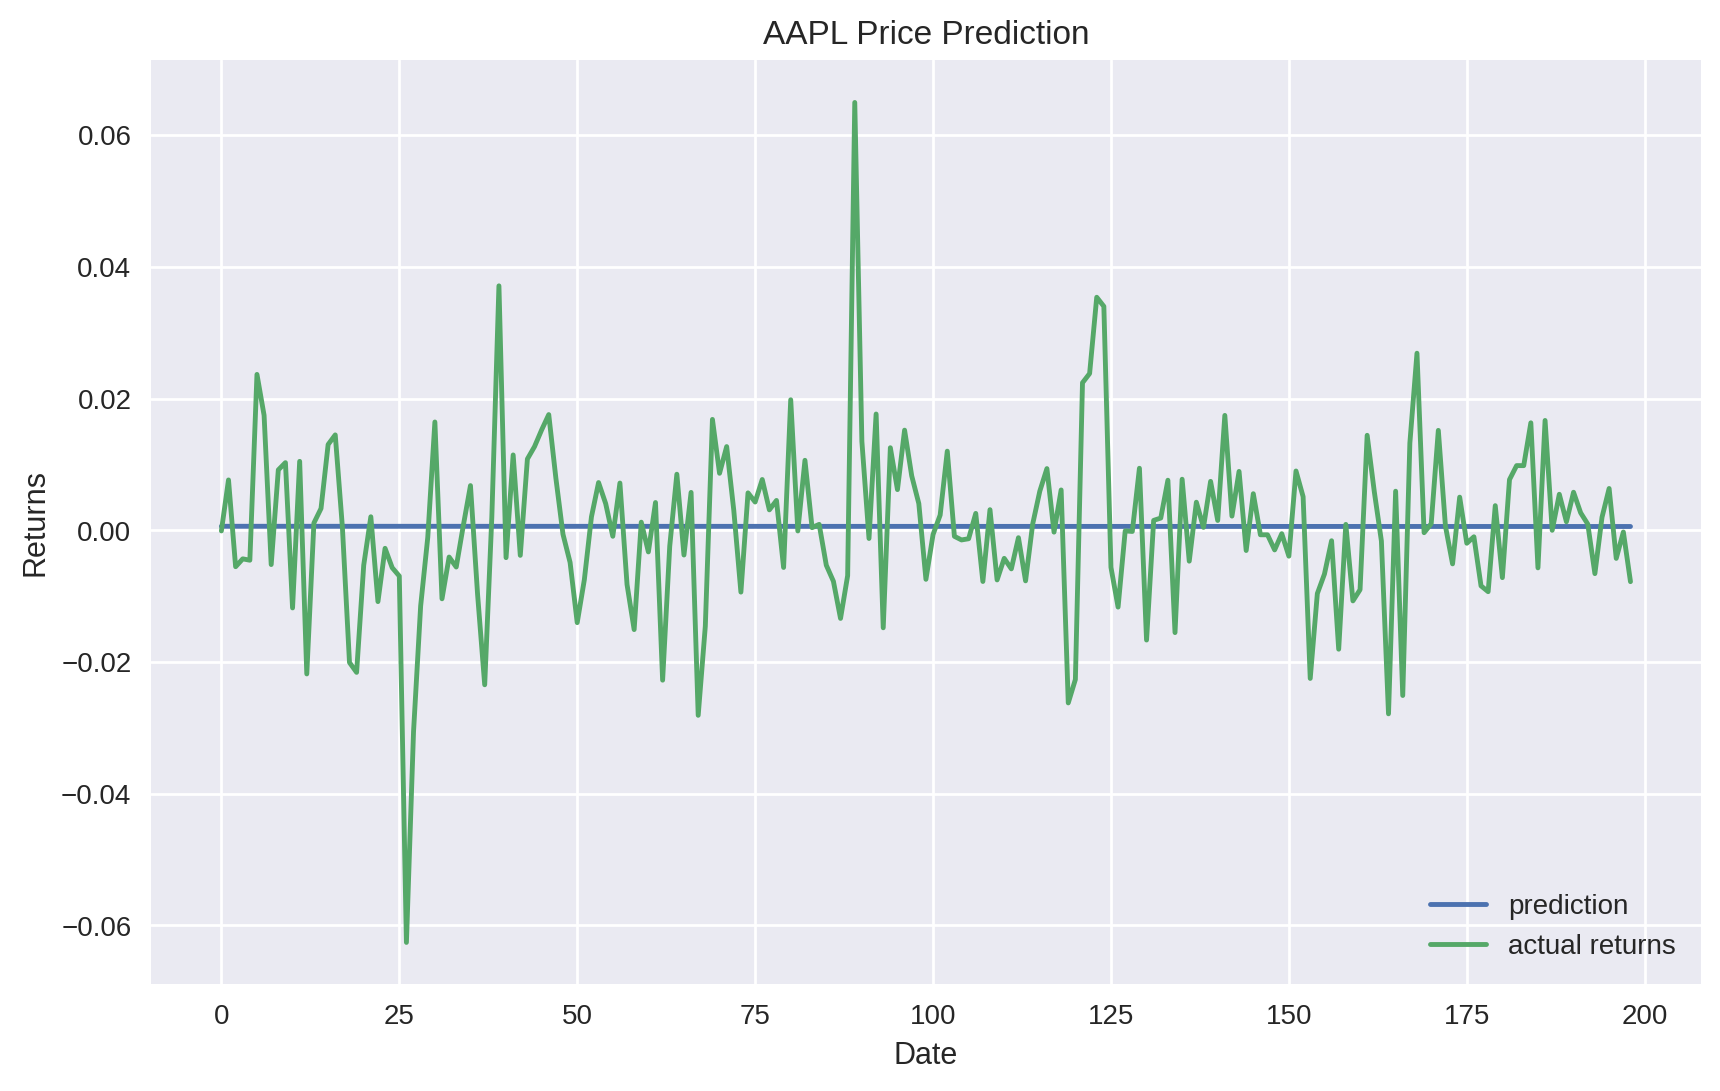

In [ ]:
# Plot returns and predictions
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Returns')
plt.plot(test_df['pred_ret'].values)
plt.plot(test_df['returns'].values)

plt.legend(["prediction",'actual returns'], loc ="lower right")

plt.title('AAPL Price Prediction')
plt.show()

In [ ]:
rmse = np.sqrt(mean_squared_error(test_df['pred_ret'],test_df['returns']))

In [ ]:
print("RMSE of baseline 2, polynomial feature linear regression:",round(rmse,3))

RMSE of baseline 2, polynomial feature linear regression: 0.013


Upon completion of the baseline model development, two predictive models have been established: a rolling average model and a polynomial linear regression model. The next phase of the analysis is focused on constructing deep learning models, specifically utilizing Long Short-Term Memory (LSTM) networks and Convolutional Neural Networks (CNN), to forecast stock returns. Preliminary correlation analysis has identified a set of 14 stocks with returns that exhibit a high degree of correlation with AAPL's returns. These stocks include 'XLP', 'CRM', 'ACN', 'MA', 'XLY', 'XLV', 'XLI', 'XLU', 'SPY', 'XLB', 'GOOG', 'IBM', 'MSFT', and 'ADBE'.

# **Neural Network Models**
Now let us experiment with neural network models. We will try various models with various input data and compare performance.

## LSTM: Only price of AAPL taken as input, returns as target variable.

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from matplotlib import pyplot as plt

In [ ]:
def lstm1(X_train, X_test, y_train, y_test, n):
  print("N VALUE:",n)
  # defining variables that can take the form of the LSTM sequence
  min_max_scaler = MinMaxScaler()

  Xtrain = []
  Xtest = []
  ytrain = []
  ytest = []

  for i in range(n,len(X_train)):
    # add the last n values as a row
    Xtrain.append(X_train[i-n:i,:X_train.shape[1]])
    # and write the ith value as prediction
    ytrain.append(y_train[i])
  print(X_train.shape)

  # similarly for the test data:
  for i in range(n,len(X_test)):
    # add the last n values as a row
    Xtest.append(X_test[i-n:i,:X_test.shape[1]])
    # and write the ith value as prediction
    ytest.append(y_test[i])

  # print(np.array(Xtrain).shape)
  Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
  # Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))

  Xtest, ytest = (np.array(Xtest), np.array(ytest))
  # Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

  print('Xtrain.shape',Xtrain.shape)
  print('Xtest.shape',Xtest.shape)

  # Now it is time to build the LSTM Model:
  model = Sequential()

  model.add(LSTM(128, return_sequences=True,activation = 'tanh',input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
  model.add(LSTM(64,activation = 'sigmoid',return_sequences = False))
  model.add(Dense(25))
  model.add(Dense(1))

  # compile the model
  model.compile(optimizer = 'adam',loss='mean_squared_error')

  # fit the model
  model.fit(Xtrain, ytrain, batch_size = 1, epochs=1)

  print("Training MSE of LSTM 1: ",model.evaluate(Xtest,ytest))

  pred_test = model.predict(Xtest)
  plt.plot()
  plt.plot(pred_test,'r')
  plt.plot(ytest,'g')
  plt.title("Predicted returns versus actual, n = " + str(n))
  plt.show()

  rmse = np.sqrt(mean_squared_error(ytest, pred_test))
  print("Out of sample RMSE: ",round(rmse,2),"for n:", n)
  return rmse

In [ ]:
# creating datasets
d1 = pd.DataFrame()
d1['returns'] = aapl_data['Adj Close'].pct_change()
d1['prices'] = aapl_data['Adj Close']
d1 = d1.dropna()

In [ ]:
train_df2 = d1[:-200]
test_df2 = d1[-200:]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
min_max_scaler = MinMaxScaler()

# Reshape and fit-transform the training data
train_prices = train_df2['prices'].values.reshape(-1, 1)
train_df2['prices'] = min_max_scaler.fit_transform(train_prices)

# Reshape and transform the test data using the same scaler
test_prices = test_df2['prices'].values.reshape(-1, 1)
test_df2['prices'] = min_max_scaler.transform(test_prices)

<ipython-input-60-6ff6c0673d53>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df2['prices'] = min_max_scaler.fit_transform(train_prices)
<ipython-input-60-6ff6c0673d53>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df2['prices'] = min_max_scaler.transform(test_prices)


In [ ]:
train_df2

,returns,prices
1,-0.084318,0.019432
2,0.014630,0.019814
3,-0.086546,0.017520
4,0.047390,0.018667
5,-0.017594,0.018221
...,...,...
4072,0.010774,0.781120
4073,0.002543,0.783123
4074,0.020093,0.798993
4075,0.013292,0.809702


In [ ]:
X_train = train_df2['prices'].values.reshape(-1,1)
X_test = test_df2['prices'].values.reshape(-1,1)

y_train = train_df2['returns'].values
y_test = test_df2['returns'].values

N VALUE: 10
(4076, 1)
Xtrain.shape (4066, 10, 1)
Xtest.shape (190, 10, 1)
6/6 [==============================] - 1s 10ms/step - loss: 1.7099e-04
Training MSE of LSTM 1:  0.00017099332762882113
6/6 [==============================] - 1s 11ms/step


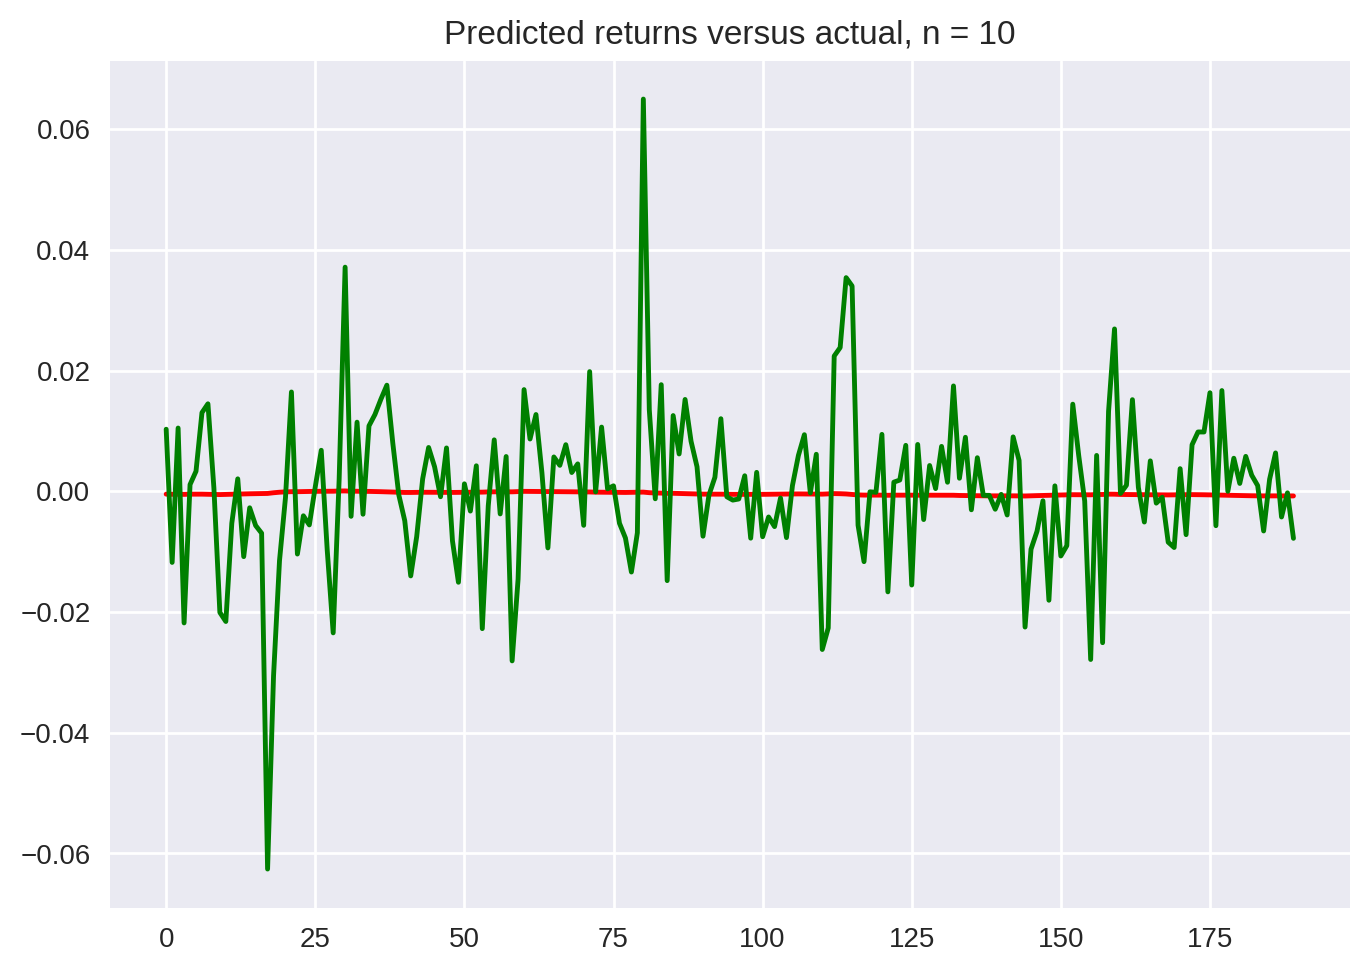

Out of sample RMSE:  0.01 for n: 10


0.013076442036996028

In [ ]:
lstm1(X_train, X_test, y_train, y_test, 10)

N VALUE: 5
(4076, 1)
Xtrain.shape (4071, 5, 1)
Xtest.shape (195, 5, 1)
7/7 [==============================] - 1s 6ms/step - loss: 4.9776e-04
Training MSE of LSTM 1:  0.000497755128890276
7/7 [==============================] - 1s 6ms/step


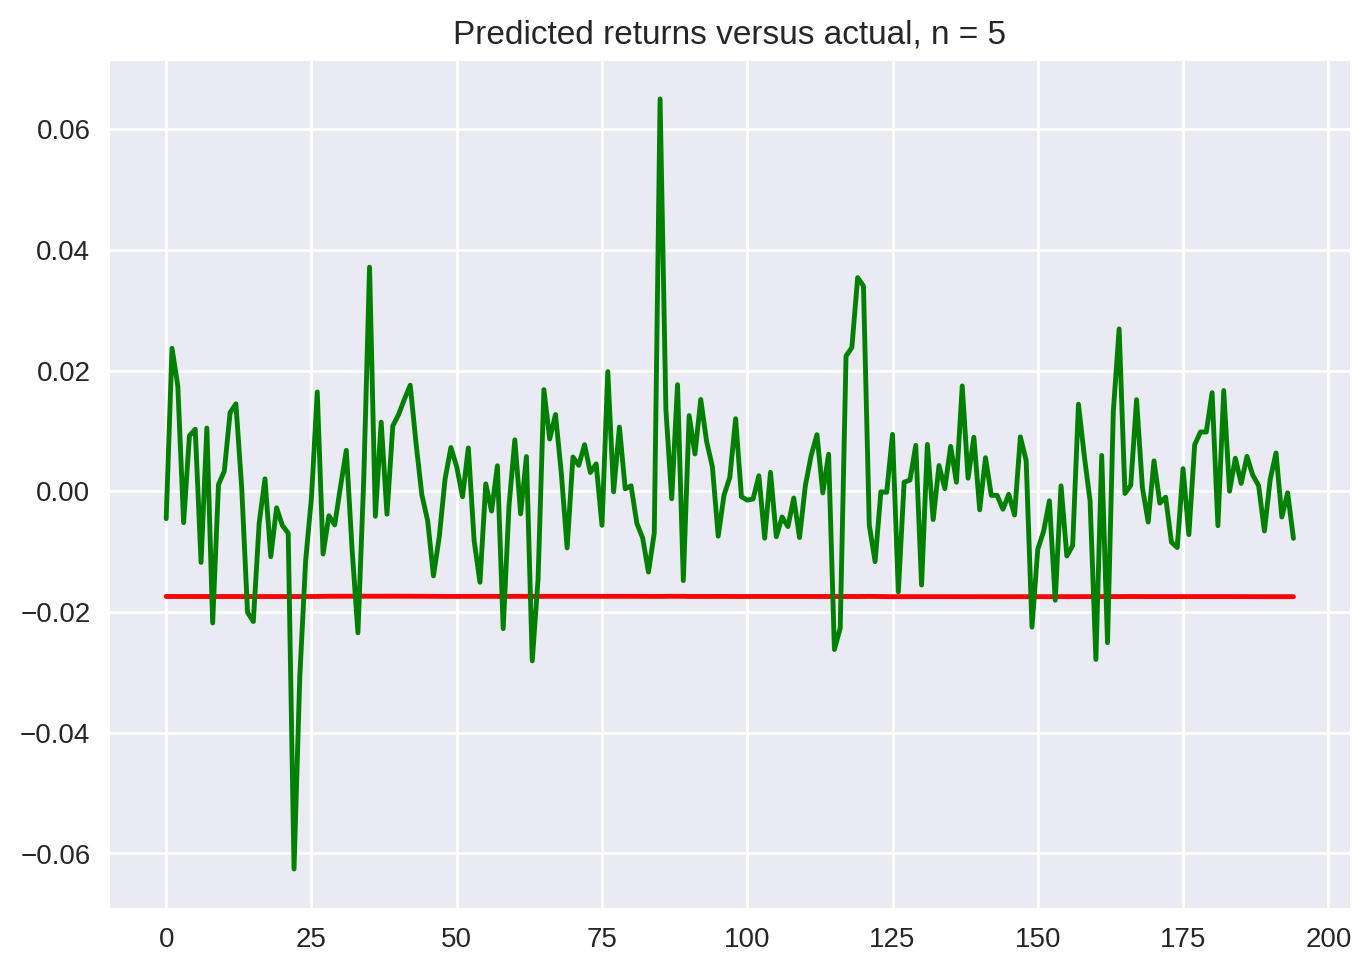

Out of sample RMSE:  0.02 for n: 5
N VALUE: 10
(4076, 1)
Xtrain.shape (4066, 10, 1)
Xtest.shape (190, 10, 1)
6/6 [==============================] - 1s 15ms/step - loss: 2.5173e-04
Training MSE of LSTM 1:  0.00025172746973112226
6/6 [==============================] - 1s 14ms/step


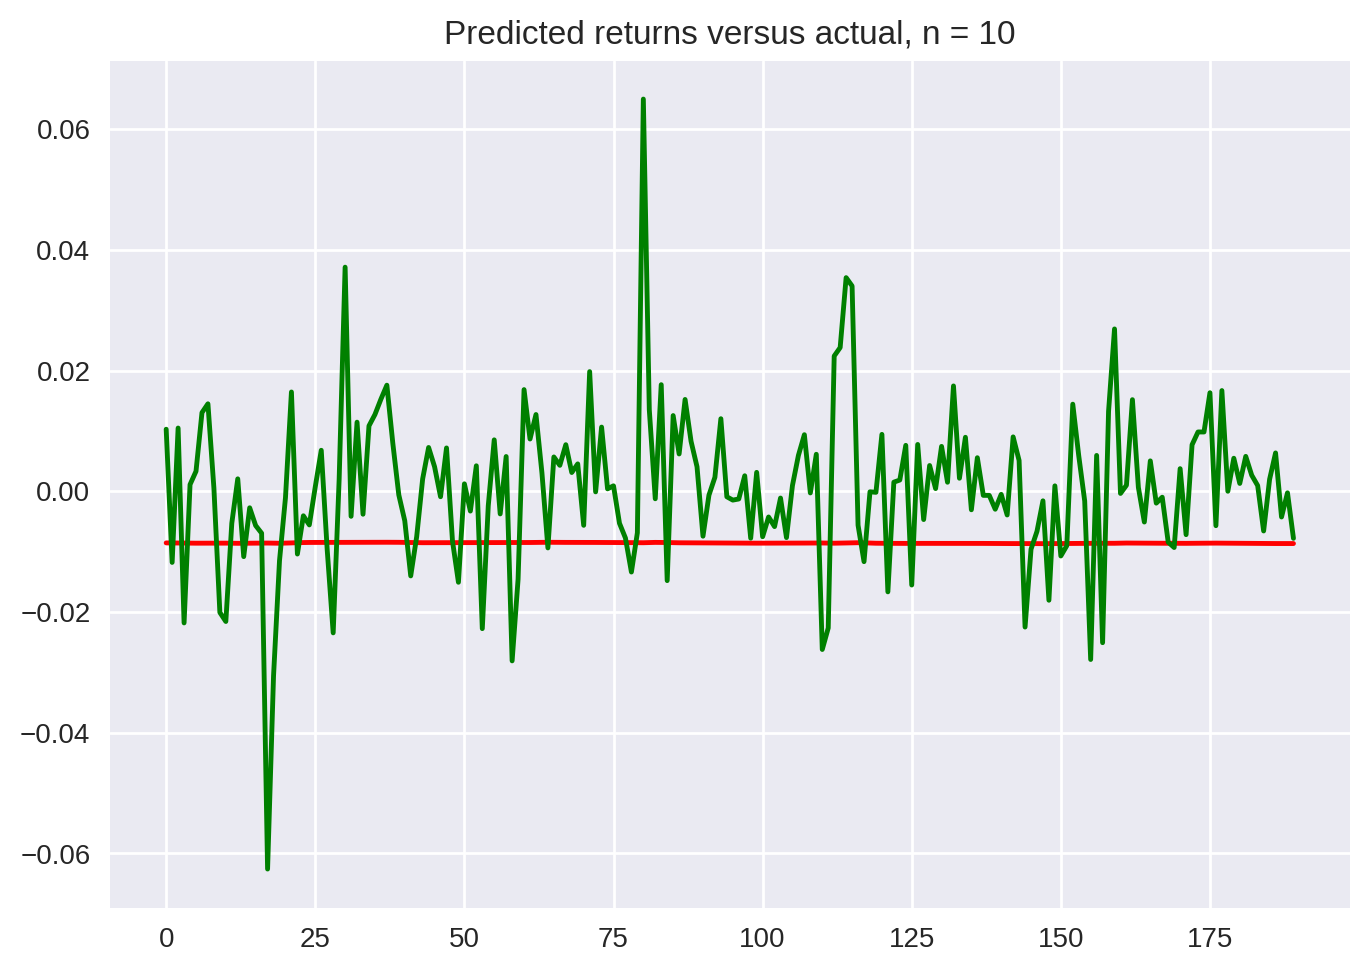

Out of sample RMSE:  0.02 for n: 10
N VALUE: 20
(4076, 1)
Xtrain.shape (4056, 20, 1)
Xtest.shape (180, 20, 1)
6/6 [==============================] - 1s 17ms/step - loss: 2.5972e-04
Training MSE of LSTM 1:  0.00025972205912694335
6/6 [==============================] - 1s 18ms/step


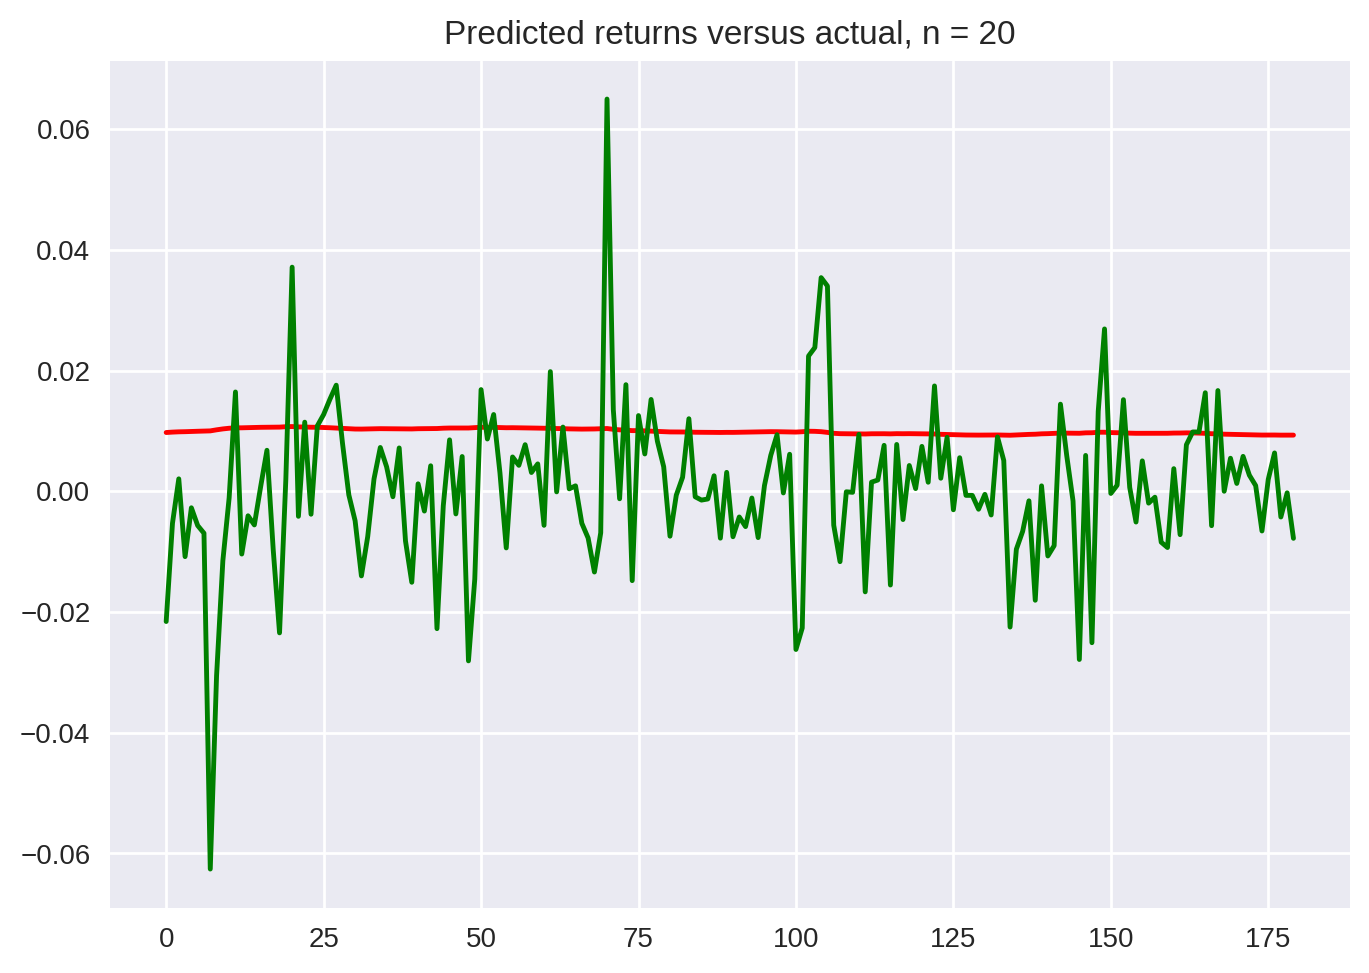

Out of sample RMSE:  0.02 for n: 20


In [ ]:
# trying for different horizon values, or n:
n_values = [5, 10, 20]
rmse_values = []
for n in n_values:
  temp_rmse = (lstm1(X_train, X_test, y_train, y_test, n))
  # print(temp_rmse)
  rmse_values.append(temp_rmse)

Text(0.5, 1.0, 'Out-of-sample RMSE as a function of horizon time (n) for LSTM 1')

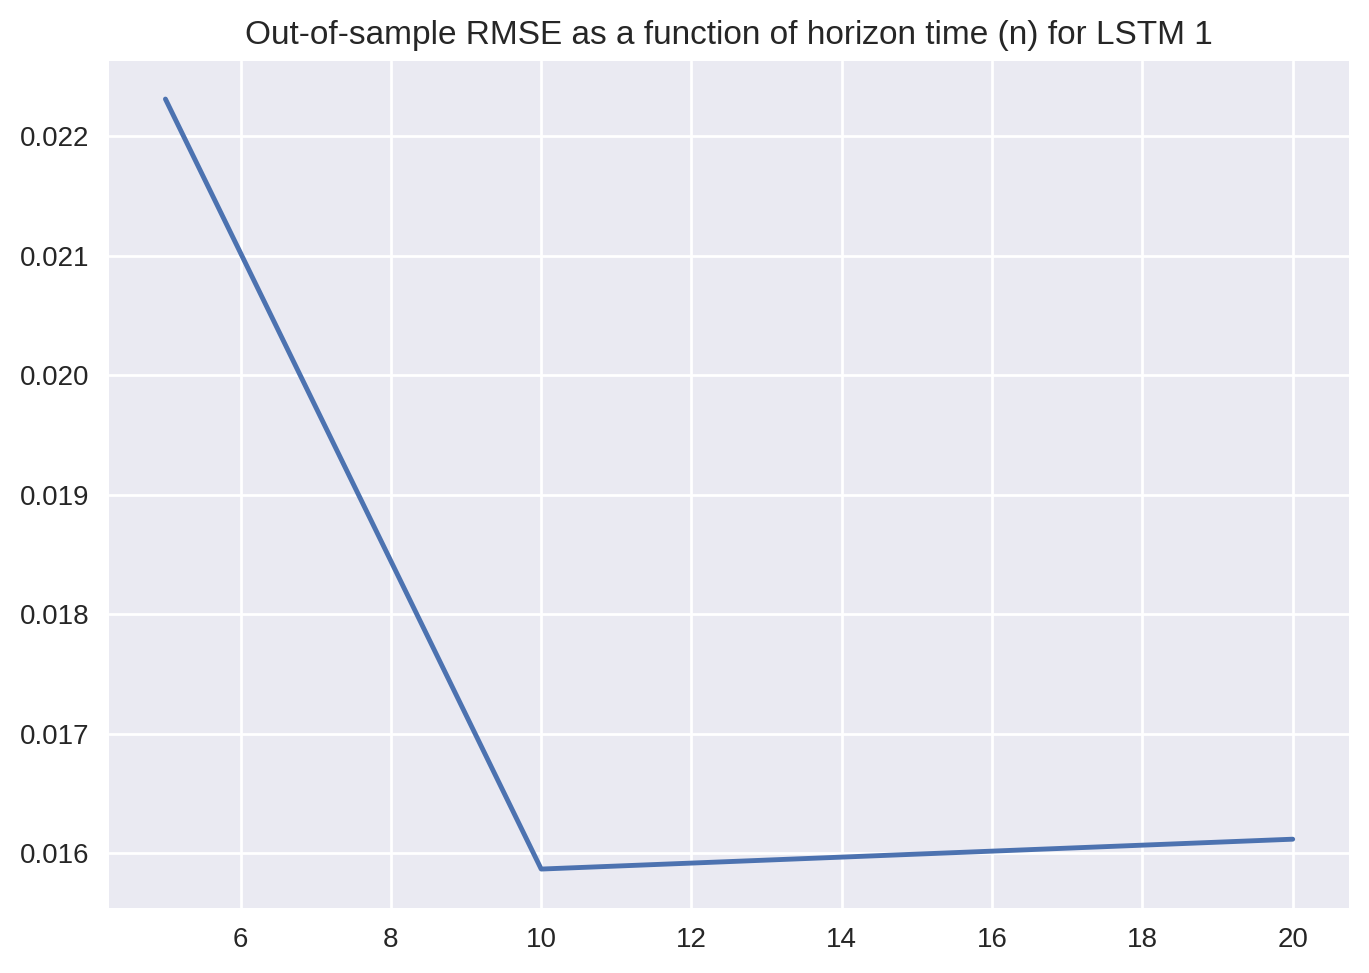

In [ ]:
plt.plot(n_values, rmse_values)
plt.title("Out-of-sample RMSE as a function of horizon time (n) for LSTM 1")

## **CNN with two features (with validation dataset): AAPL Adj Close and SP Returns**

In [ ]:
prices = datawithsp.copy()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

def cnn1_val(prices, seq_length):
    # Calculate returns
    prices['SPY_ret'] = prices["SPY"].pct_change(1)
    prices['AAPL_returns'] = prices['AAPL'].pct_change(1)

    # Drop NaN values
    prices = prices[1:]


    def create_sequences(data, seq_length):
      xs, ys = [], []
      for i in range(len(data) - seq_length):
          x = data[['AAPL', 'SPY_ret']].iloc[i:(i + seq_length)].values
          y = data['AAPL_returns'].iloc[i + seq_length]
          xs.append(x)
          ys.append(y)
      return np.array(xs), np.array(ys)


    # Split the data into training and test sets before normalization and sequence creation
    train_prices = prices[:-200]  # All data except last 200 days for training
    test_prices = prices[-200-seq_length:]  # Last 200 + seq_length days for testing

    # Normalize the training data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_prices[['AAPL', 'SPY_ret']])
    train_prices[['AAPL', 'SPY_ret']] = train_scaled

    # Scale the test data
    test_scaled = scaler.transform(test_prices[['AAPL', 'SPY_ret']])
    test_prices[['AAPL', 'SPY_ret']] = test_scaled

    # Create sequences for training
    X_train, y_train = create_sequences(train_prices, seq_length)
    # print(X_train.shape)

    # Split the training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # Create sequences for testing
    X_test, y_test = create_sequences(test_prices, seq_length)

    # Build the CNN model
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, 2)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model with validation set
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

    # Evaluate the model
    predictions = model.predict(X_test)

    plt.plot(predictions, 'r', label='Predicted Returns')
    plt.plot(y_test, 'g', label='Actual Returns')
    plt.title("Predicted vs Actual Returns (CNN1 with Val), seq_length = " + str(seq_length))
    plt.legend()
    plt.show()
    # print(model.layers[0].input_shape)
    plt.plot()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.show()


    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print('Test RMSE:', rmse)
    return rmse


<ipython-input-67-29065c583b48>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_prices[['AAPL', 'SPY_ret']] = train_scaled
<ipython-input-67-29065c583b48>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prices[['AAPL', 'SPY_ret']] = test_scaled


Epoch 1/10
102/102 [==============================] - 2s 8ms/step - loss: 8.2586e-04 - val_loss: 7.8707e-04
Epoch 2/10
102/102 [==============================] - 1s 5ms/step - loss: 7.8148e-04 - val_loss: 7.5850e-04
Epoch 3/10
102/102 [==============================] - 0s 5ms/step - loss: 7.6368e-04 - val_loss: 8.0621e-04
Epoch 4/10
102/102 [==============================] - 0s 5ms/step - loss: 7.7751e-04 - val_loss: 8.4932e-04
Epoch 5/10
102/102 [==============================] - 1s 5ms/step - loss: 7.6705e-04 - val_loss: 7.7948e-04
Epoch 6/10
102/102 [==============================] - 1s 5ms/step - loss: 7.6578e-04 - val_loss: 7.5669e-04
Epoch 7/10
102/102 [==============================] - 1s 5ms/step - loss: 7.5791e-04 - val_loss: 7.6181e-04
Epoch 8/10
102/102 [==============================] - 0s 5ms/step - loss: 7.5860e-04 - val_loss: 7.6087e-04
Epoch 9/10
102/102 [==============================] - 0s 3ms/step - loss: 7.4647e-04 - val_loss: 7.6188e-04
Epoch 10/10
7/7 [===========

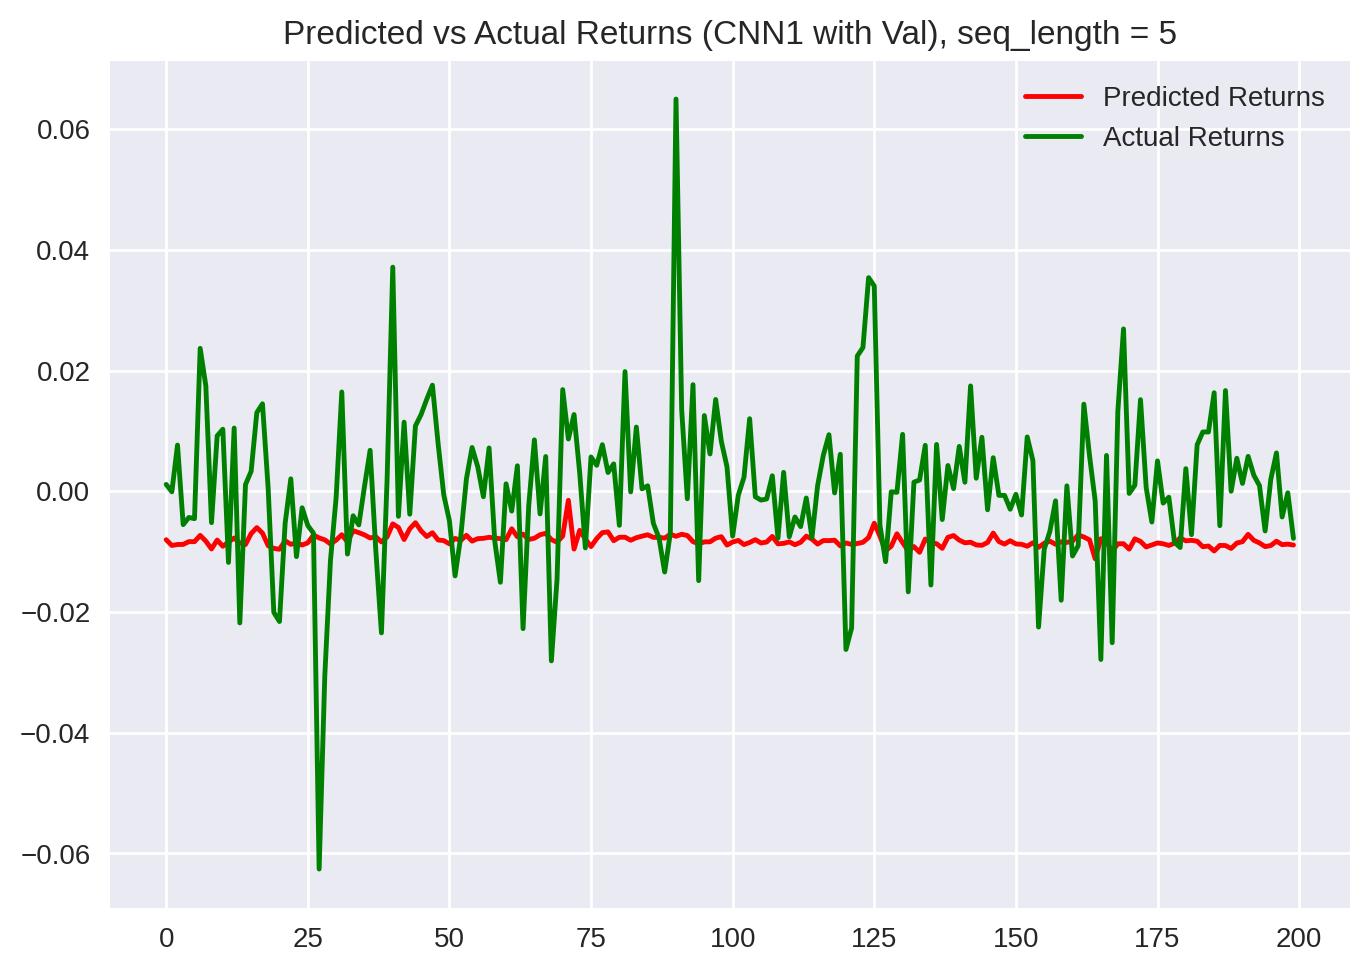

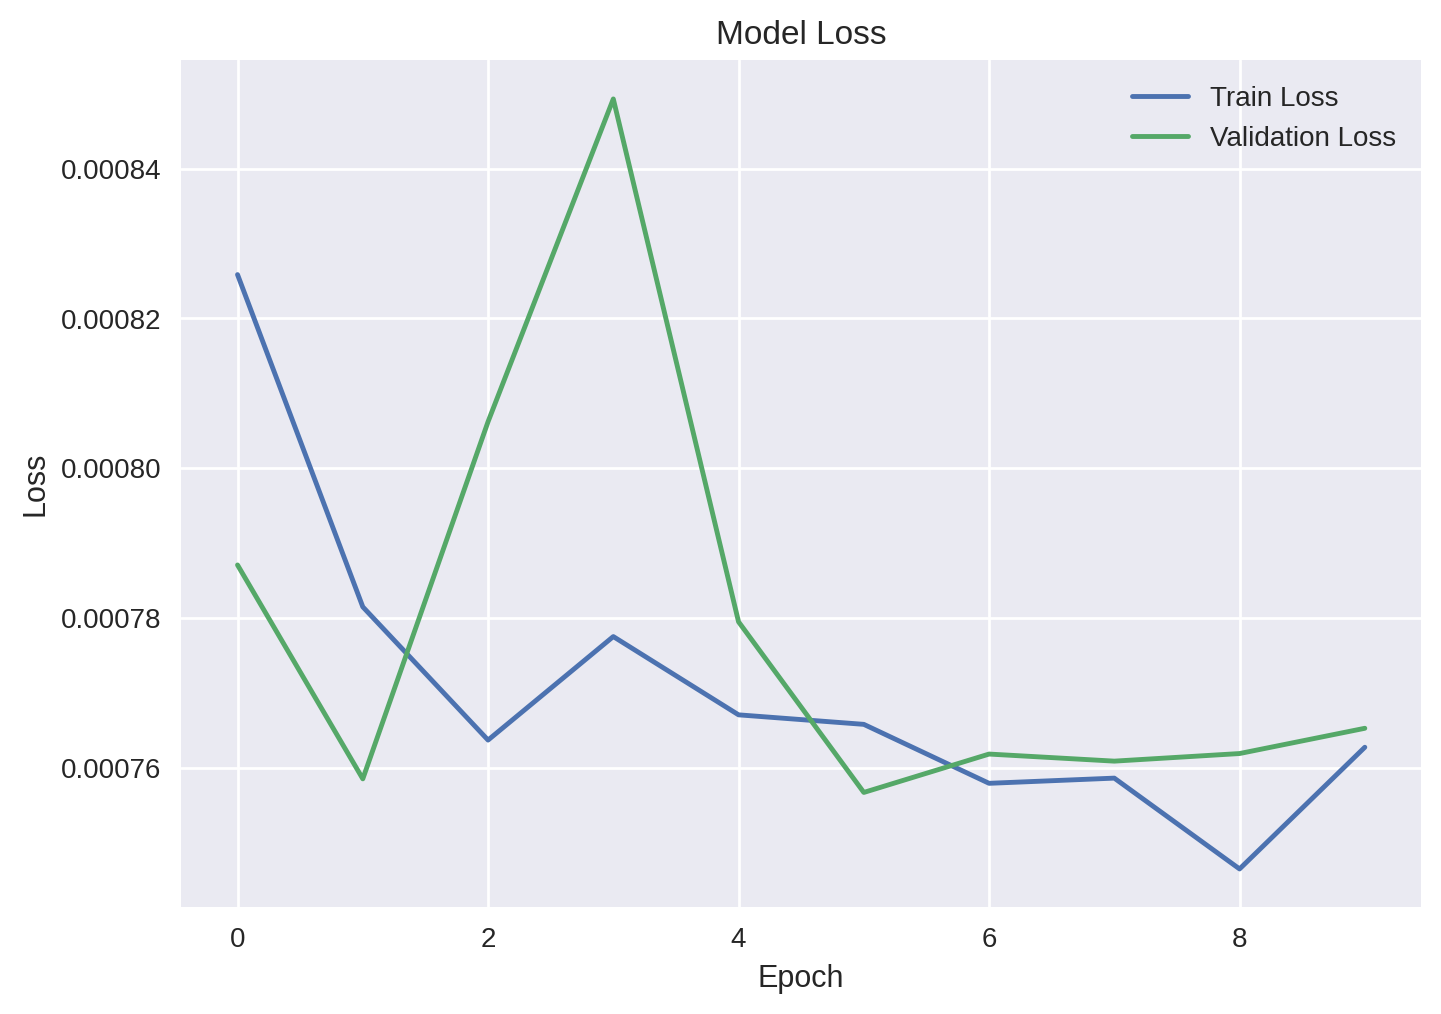

Test RMSE: 0.015475152345163681


In [ ]:
# Call your function with the 'prices' DataFrame and a sequence length
# prices should be a DataFrame containing 'AAPL' and 'SPY' columns
seq_length = 5
rmse = cnn1_val(prices, seq_length)

The results are consistent and much more satisfactory! I will now continue trying to make it better!

## CNN with Multiple Features and Utilising Lasso Regression for feature selection

Here is my idea:
There are multiple stocks that I can select data from. I want to utilise the large amount of data provded to me and I will now use lasso regression to eliminate some features (by find the features whose coefficients go to zero) and utilise those features to build a CNN model to see if we can further reduce the loss. I will use the top 14 stocks (excluding V). This process was seen in the EDA step.

In [ ]:
# first let's create the dataset
# please scroll up to find the generation of alldata15: a dataset consisting of the 15 most highly correlated stocks with AAPL
# I dropped V from that dataset
# to be safe, I am regenerating the dataset so that I can be sure
# I am also adding AAPL to the columns, since I had removed it for correlation
stock_arr = alldata15.columns

In [ ]:
stock_list = list(stock_arr)

In [ ]:
stock_list.append('AAPL')

In [ ]:
print(stock_list)

['XLP', 'CRM', 'ACN', 'MA', 'XLY', 'XLV', 'XLI', 'XLU', 'SPY', 'XLB', 'GOOG', 'IBM', 'MSFT', 'ADBE', 'AAPL']


In [ ]:
data_14stocks, x_train, x_test, y_train, y_test = data_generate_process(stock_list)

In [ ]:
data_14stocks

,XLP,CRM,ACN,MA,XLY,XLV,XLI,XLU,SPY,XLB,GOOG,IBM,MSFT,ADBE,AAPL
Dt,,,,,,,,,,,,,,,
2000-01-03,14.4300,NaN,NaN,NaN,23.6030,22.8577,20.0644,13.4984,100.4705,16.4831,NaN,76.4112,37.6233,16.2747,3.4785
2000-01-04,14.0237,NaN,NaN,NaN,22.8930,22.3390,19.5101,13.0913,96.5415,16.3244,NaN,73.8175,36.3524,14.9094,3.1852
2000-01-05,14.2715,NaN,NaN,NaN,22.6114,22.1386,19.4232,13.4216,96.7142,16.9988,NaN,76.4112,36.7357,15.2042,3.2318
2000-01-06,14.5391,NaN,NaN,NaN,22.8685,22.2093,19.6840,13.3986,95.1599,17.4352,NaN,75.0938,35.5051,15.3283,2.9521
2000-01-07,15.4608,NaN,NaN,NaN,23.9458,22.4804,20.4340,13.5138,100.6864,17.4253,NaN,74.7644,35.9691,16.0730,3.0920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,48.2980,69.87,111.7080,102.8042,79.5679,66.5372,59.7018,44.4429,214.2890,47.6722,789.91,146.5132,60.1241,105.0200,111.3073
2016-12-27,48.2887,69.85,111.7746,102.8926,79.8767,66.6713,59.8250,44.4795,214.8206,47.9283,791.55,146.8911,60.1621,104.9800,112.0142
2016-12-28,47.9918,69.09,110.8808,101.7930,79.3267,66.1636,59.1994,44.0589,213.0452,47.4446,785.05,146.0562,59.8864,103.7700,111.5366


In [ ]:
# creating input DataFrames for the Lasso Process
data = data_14stocks.copy()
target = data_14stocks['AAPL'].pct_change(1)

In [ ]:
data = data[1:]
data

,XLP,CRM,ACN,MA,XLY,XLV,XLI,XLU,SPY,XLB,GOOG,IBM,MSFT,ADBE,AAPL
Dt,,,,,,,,,,,,,,,
2000-01-04,14.0237,NaN,NaN,NaN,22.8930,22.3390,19.5101,13.0913,96.5415,16.3244,NaN,73.8175,36.3524,14.9094,3.1852
2000-01-05,14.2715,NaN,NaN,NaN,22.6114,22.1386,19.4232,13.4216,96.7142,16.9988,NaN,76.4112,36.7357,15.2042,3.2318
2000-01-06,14.5391,NaN,NaN,NaN,22.8685,22.2093,19.6840,13.3986,95.1599,17.4352,NaN,75.0938,35.5051,15.3283,2.9521
2000-01-07,15.4608,NaN,NaN,NaN,23.9458,22.4804,20.4340,13.5138,100.6864,17.4253,NaN,74.7644,35.9691,16.0730,3.0920
2000-01-10,15.1139,NaN,NaN,NaN,23.8234,24.7792,20.4340,13.5599,101.0318,17.3658,NaN,77.7287,36.2313,16.6936,3.0376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,48.2980,69.87,111.7080,102.8042,79.5679,66.5372,59.7018,44.4429,214.2890,47.6722,789.91,146.5132,60.1241,105.0200,111.3073
2016-12-27,48.2887,69.85,111.7746,102.8926,79.8767,66.6713,59.8250,44.4795,214.8206,47.9283,791.55,146.8911,60.1621,104.9800,112.0142
2016-12-28,47.9918,69.09,110.8808,101.7930,79.3267,66.1636,59.1994,44.0589,213.0452,47.4446,785.05,146.0562,59.8864,103.7700,111.5366


In [ ]:
target = target[1:]
target

Dt
2000-01-04   -0.084318
2000-01-05    0.014630
2000-01-06   -0.086546
2000-01-07    0.047390
2000-01-10   -0.017594
                ...   
2016-12-23    0.001978
2016-12-27    0.006351
2016-12-28   -0.004264
2016-12-29   -0.000257
2016-12-30   -0.007796
Name: AAPL, Length: 4276, dtype: float64

In [ ]:
from sklearn.impute import SimpleImputer

# Imputer object using the mean strategy and
# missing_values type for imputation
imputer = SimpleImputer(missing_values = np.nan,
                        strategy ='median')

In [ ]:
data_filled = imputer.fit_transform(data)

In [ ]:
data_filled = pd.DataFrame(data_filled, columns = data.columns)

In [ ]:
data_filled

,XLP,CRM,ACN,MA,XLY,XLV,XLI,XLU,SPY,XLB,GOOG,IBM,MSFT,ADBE,AAPL
0,14.0237,26.4075,30.6198,31.0867,22.8930,22.3390,19.5101,13.0913,96.5415,16.3244,287.1836,73.8175,36.3524,14.9094,3.1852
1,14.2715,26.4075,30.6198,31.0867,22.6114,22.1386,19.4232,13.4216,96.7142,16.9988,287.1836,76.4112,36.7357,15.2042,3.2318
2,14.5391,26.4075,30.6198,31.0867,22.8685,22.2093,19.6840,13.3986,95.1599,17.4352,287.1836,75.0938,35.5051,15.3283,2.9521
3,15.4608,26.4075,30.6198,31.0867,23.9458,22.4804,20.4340,13.5138,100.6864,17.4253,287.1836,74.7644,35.9691,16.0730,3.0920
4,15.1139,26.4075,30.6198,31.0867,23.8234,24.7792,20.4340,13.5599,101.0318,17.3658,287.1836,77.7287,36.2313,16.6936,3.0376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4271,48.2980,69.8700,111.7080,102.8042,79.5679,66.5372,59.7018,44.4429,214.2890,47.6722,789.9100,146.5132,60.1241,105.0200,111.3073
4272,48.2887,69.8500,111.7746,102.8926,79.8767,66.6713,59.8250,44.4795,214.8206,47.9283,791.5500,146.8911,60.1621,104.9800,112.0142
4273,47.9918,69.0900,110.8808,101.7930,79.3267,66.1636,59.1994,44.0589,213.0452,47.4446,785.0500,146.0562,59.8864,103.7700,111.5366
4274,48.2145,69.1500,111.2611,101.8813,79.2205,66.2785,59.1805,44.6532,212.9978,47.4446,782.7900,146.4165,59.8008,103.6800,111.5079


In [ ]:
from sklearn.linear_model import LassoCV

# Assuming 'data' is a DataFrame with all your features and 'target' is your target variable (returns)
lasso = LassoCV(cv=5, random_state=42).fit(data_filled, target)
important_features = [feature for feature, coef in zip(data.columns, lasso.coef_) if coef != 0]

In [ ]:
important_features

['GOOG']

Interesting! The filled Google values seem to explain AAPL returns more than the stock itself: that's counterintuitive, but the data shows that. So now I will build two more models:

Forecasting AAPL returns using only GOOG prices (but with imputed values)
And forecasting AAPL returns using AAPL and GOOG prices (again, both imputed values)

### CNN with only GOOG prices to predict AAPL returns




In [ ]:
# defining stock list and redoing data extraction
stock_list = ["GOOG","AAPL"]
goog, x_train, x_test, y_train, y_test = data_generate_process(stock_list)

In [ ]:
goog

,GOOG,AAPL
Dt,,
2000-01-03,NaN,3.4785
2000-01-04,NaN,3.1852
2000-01-05,NaN,3.2318
2000-01-06,NaN,2.9521
2000-01-07,NaN,3.0920
...,...,...
2016-12-23,789.91,111.3073
2016-12-27,791.55,112.0142
2016-12-28,785.05,111.5366


In [ ]:
from sklearn.impute import SimpleImputer

# Imputer object using the mean strategy and
# missing_values type for imputation
imputer = SimpleImputer(missing_values = np.nan,
                        strategy ='median')
goog_filled = imputer.fit_transform(goog)

In [ ]:
goog = pd.DataFrame(goog_filled, columns = goog.columns)

In [ ]:
goog

,GOOG,AAPL
0,287.1836,3.4785
1,287.1836,3.1852
2,287.1836,3.2318
3,287.1836,2.9521
4,287.1836,3.0920
...,...,...
4272,789.9100,111.3073
4273,791.5500,112.0142
4274,785.0500,111.5366
4275,782.7900,111.5079


In [ ]:
x_train_filled = imputer.fit_transform(x_train)
x_train = pd.DataFrame(x_train_filled, columns = x_train.columns)

In [ ]:
x_train

,GOOG,AAPL
0,276.4637,3.1852
1,276.4637,3.2318
2,276.4637,2.9521
3,276.4637,3.0920
4,276.4637,3.0376
...,...,...
4071,726.8200,96.0777
4072,730.4900,96.3220
4073,728.3300,98.2574
4074,736.0900,99.5634


In [ ]:
x_test.isna().value_counts()

GOOG   AAPL 
False  False    199
dtype: int64

In [ ]:
y_test.isna().any()

False

In [ ]:
y_train.isna().any()

False

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Function to create sequences for training the CNN
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:(i + seq_length)].values)
        y.append(target.iloc[i + seq_length])
    return np.array(X), np.array(y)

# Function to train and evaluate the CNN model
def train_cnn_model(X_train, y_train, X_val, y_val, X_test, y_test, seq_length, n_features):
    # Build the CNN model
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, n_features)),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        verbose=1,
        validation_data=(X_val, y_val)
    )

    # Evaluate the model on the test set
    test_pred = model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
    print(f'Test RMSE: {test_rmse:.4f}')

    # Plot the training and validation loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

    # Plot predictions vs actual returns
    plt.figure(figsize=(10, 5))
    plt.plot(test_pred, 'r', label='Predicted Returns')
    plt.plot(y_test, 'g', label='Actual Returns')
    plt.title("Predicted vs Actual Returns")
    plt.legend()
    plt.show()

    return model



Epoch 1/10
81/81 [==============================] - 1s 6ms/step - loss: 0.0011 - val_loss: 3.2229e-04
Epoch 2/10
81/81 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 3.1694e-04
Epoch 3/10
81/81 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 3.2613e-04
Epoch 4/10
81/81 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 3.3577e-04
Epoch 5/10
81/81 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 3.1530e-04
Epoch 6/10
81/81 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 3.2281e-04
Epoch 7/10
81/81 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 4.1161e-04
Epoch 8/10
81/81 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 3.4087e-04
Epoch 9/10
81/81 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 3.1111e-04
Epoch 10/10
27/27 [==============================] - 0s 2ms/step
Test RMSE: 0.0156

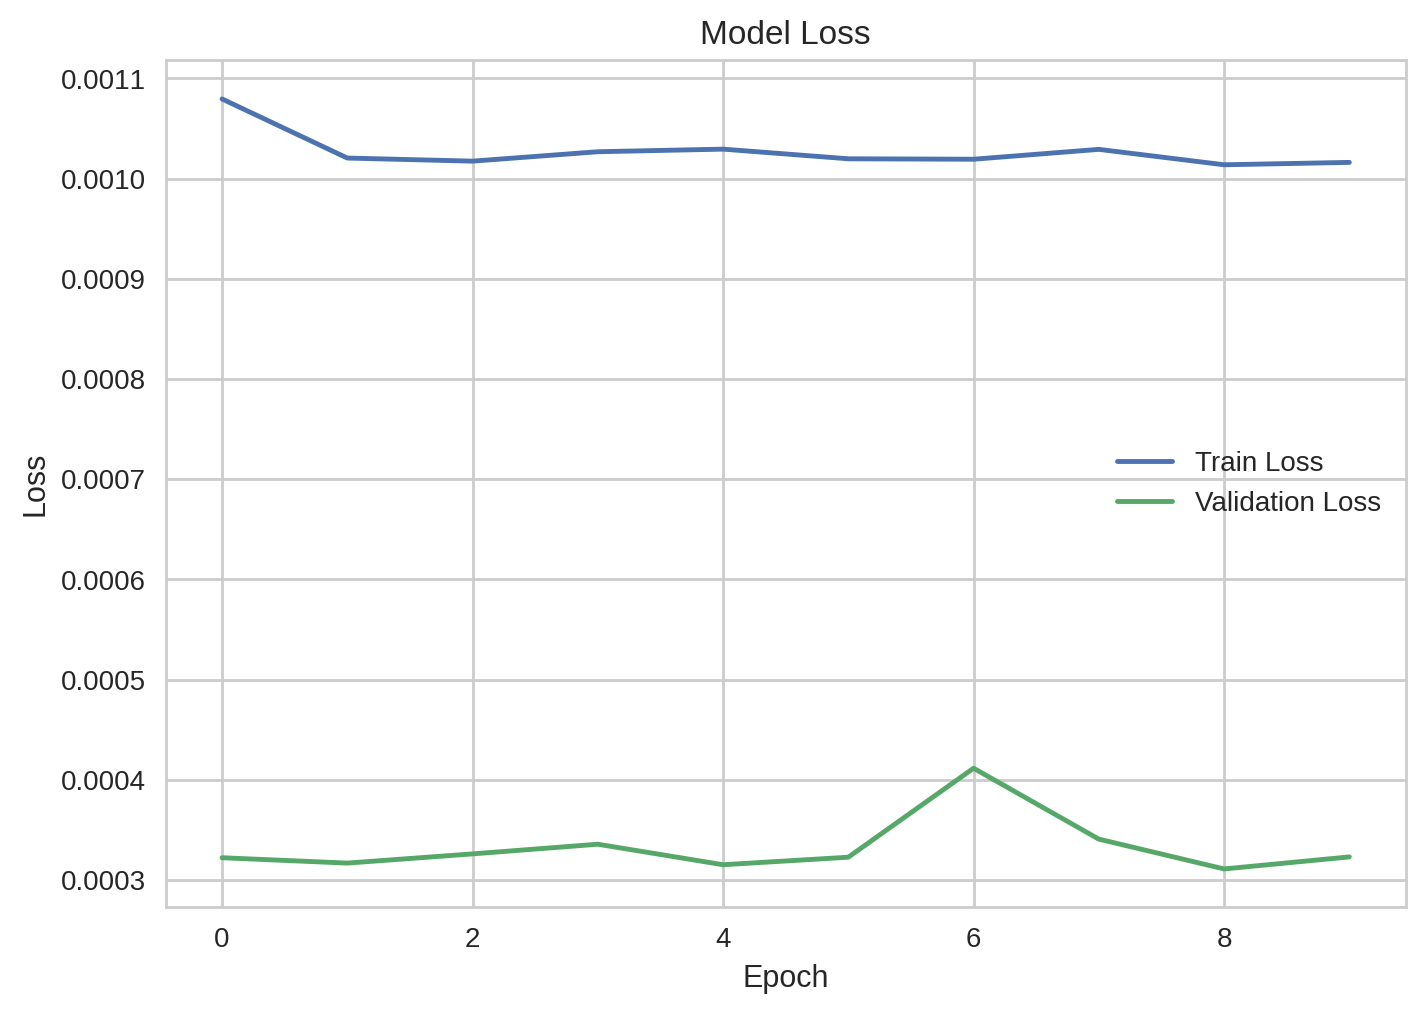

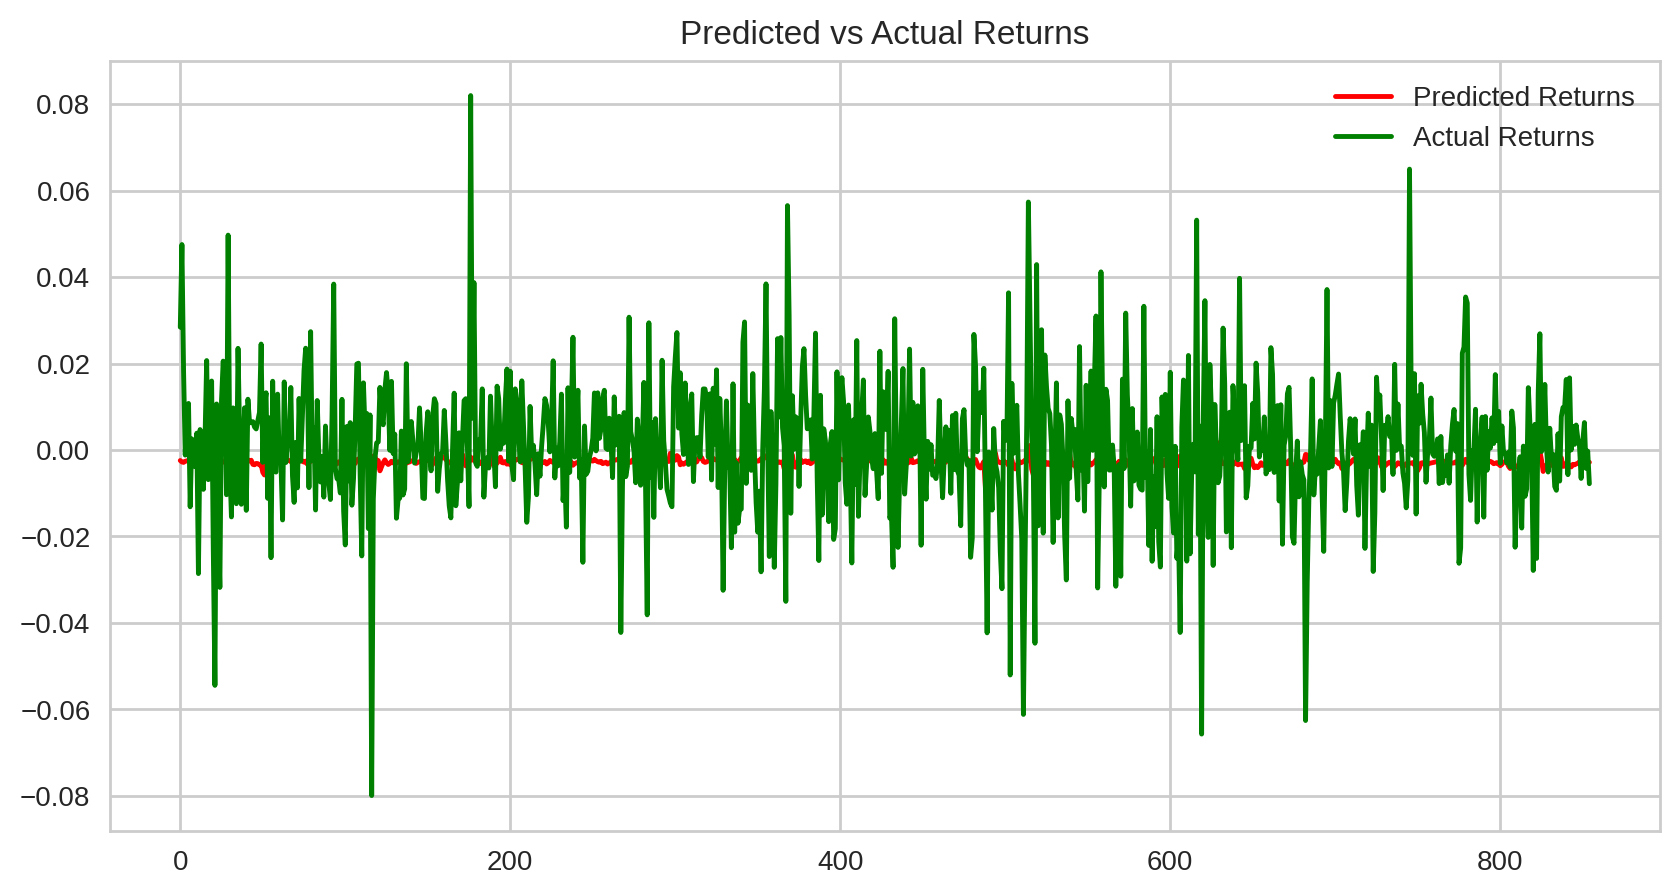

In [ ]:
seq_length = 5  # Number of time steps in the sequence
scaler = MinMaxScaler()

features = ['GOOG']
df_scaled = scaler.fit_transform(goog[features])
df_scaled = pd.DataFrame(df_scaled, columns=features)
df_scaled = df_scaled[1:]

# Assume 'AAPL_returns' is the target and already scaled if necessary
target = goog['AAPL'].pct_change(1)
target = target[1:]

# Create sequences
X, y = create_sequences(df_scaled, target, seq_length)

# Split the data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, shuffle=False)  # 0.25 x 0.8 = 0.2

# Train and evaluate the CNN model
n_features = X.shape[2]  # Number of features
model = train_cnn_model(X_train, y_train, X_val, y_val, X_test, y_test, seq_length, n_features)

The RMSE is less! But let's see the other model: with both GOOG and AAPL.

### CNN with AAPL and GOOG prices to predict AAPL returns


Epoch 1/10
81/81 [==============================] - 1s 9ms/step - loss: 0.0011 - val_loss: 3.2698e-04
Epoch 2/10
81/81 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 3.1640e-04
Epoch 3/10
81/81 [==============================] - 1s 6ms/step - loss: 0.0010 - val_loss: 3.2175e-04
Epoch 4/10
81/81 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 3.1584e-04
Epoch 5/10
81/81 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 3.2212e-04
Epoch 6/10
81/81 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 3.1303e-04
Epoch 7/10
81/81 [==============================] - 0s 6ms/step - loss: 0.0010 - val_loss: 3.1256e-04
Epoch 8/10
81/81 [==============================] - 1s 7ms/step - loss: 0.0010 - val_loss: 3.6997e-04
Epoch 9/10
81/81 [==============================] - 0s 5ms/step - loss: 0.0010 - val_loss: 3.8054e-04
Epoch 10/10
27/27 [==============================] - 0s 3ms/step
Test RMSE: 0.0250

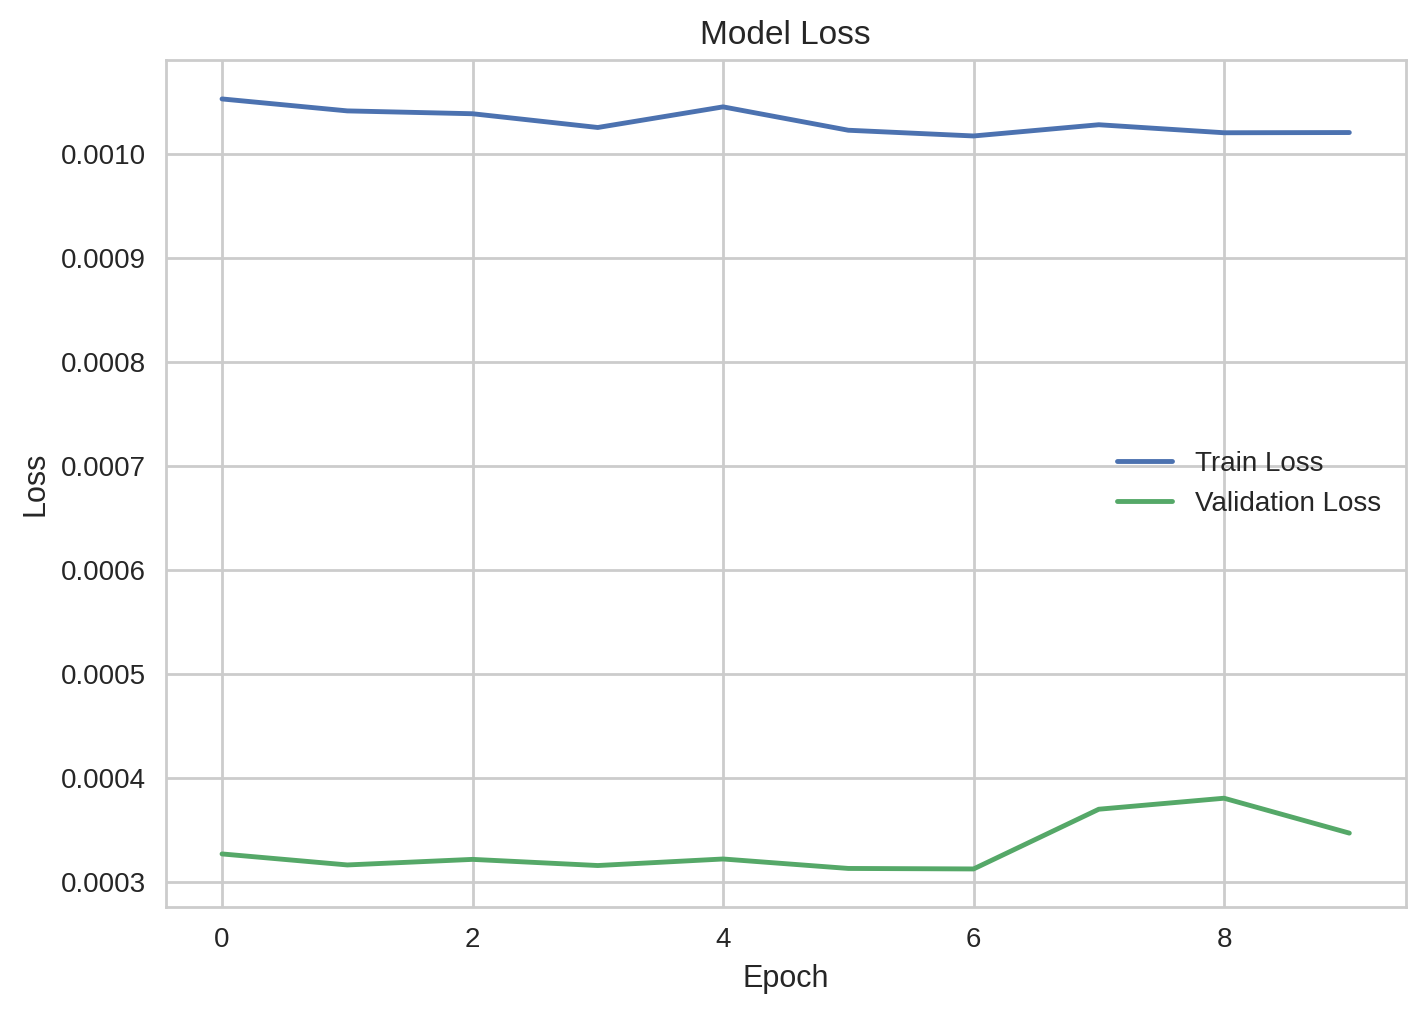

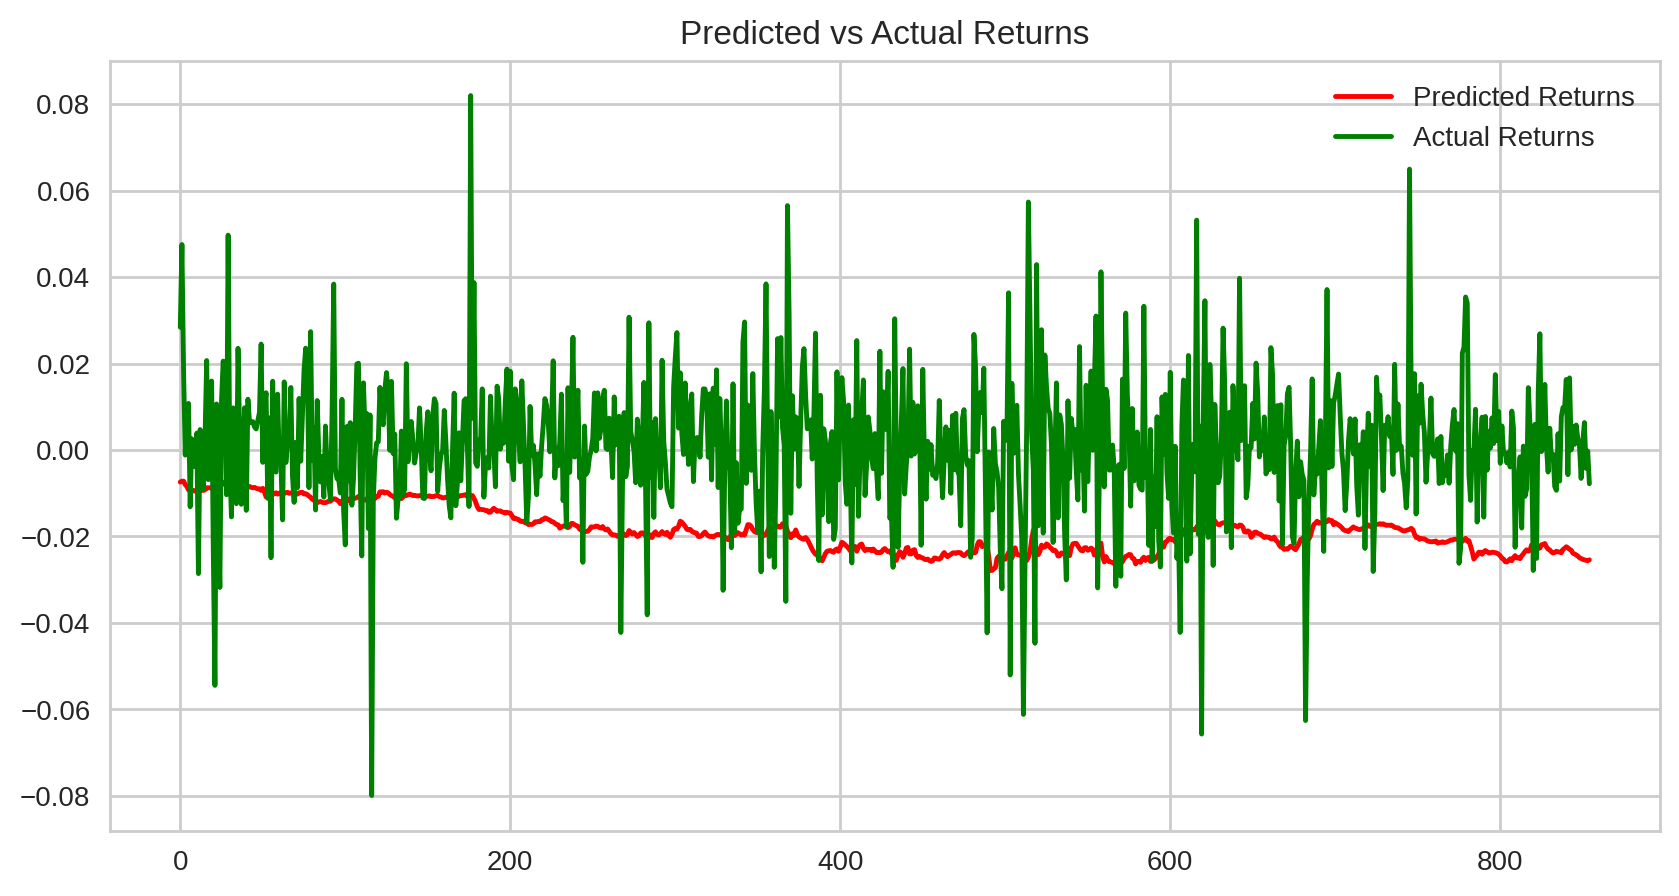

In [ ]:
seq_length = 5  # Number of time steps in the sequence
scaler = MinMaxScaler()

features = ['GOOG','AAPL']
df_scaled = scaler.fit_transform(goog[features])
df_scaled = pd.DataFrame(df_scaled, columns=features)
df_scaled = df_scaled[1:]

# Assume 'AAPL_returns' is the target and already scaled if necessary
target = goog['AAPL'].pct_change(1)
target = target[1:]

# Create sequences
X, y = create_sequences(df_scaled, target, seq_length)

# Split the data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, shuffle=False)  # 0.25 x 0.8 = 0.2

# Train and evaluate the CNN model
n_features = X.shape[2]  # Number of features
model = train_cnn_model(X_train, y_train, X_val, y_val, X_test, y_test, seq_length, n_features)

### CNN with AAPL, SPY, GOOG prices to predict AAPL returns


In [ ]:
data_new = get_adj_close_data(['GOOG','AAPL','SPY'])

In [ ]:
data_new

,GOOG,AAPL,SPY
Dt,,,
2000-01-03,NaN,3.4785,100.4705
2000-01-04,NaN,3.1852,96.5415
2000-01-05,NaN,3.2318,96.7142
2000-01-06,NaN,2.9521,95.1599
2000-01-07,NaN,3.0920,100.6864
...,...,...,...
2016-12-23,789.91,111.3073,214.2890
2016-12-27,791.55,112.0142,214.8206
2016-12-28,785.05,111.5366,213.0452


In [ ]:
from sklearn.impute import SimpleImputer

# Imputer object using the mean strategy and
# missing_values type for imputation
imputer = SimpleImputer(missing_values = np.nan,
                        strategy ='median')
data_new_filled = imputer.fit_transform(data_new)

In [ ]:
data_new = pd.DataFrame(data_new_filled, columns = data_new.columns)

In [ ]:
data_new

,GOOG,AAPL,SPY
0,287.1836,3.4785,100.4705
1,287.1836,3.1852,96.5415
2,287.1836,3.2318,96.7142
3,287.1836,2.9521,95.1599
4,287.1836,3.0920,100.6864
...,...,...,...
4272,789.9100,111.3073,214.2890
4273,791.5500,112.0142,214.8206
4274,785.0500,111.5366,213.0452
4275,782.7900,111.5079,212.9978


Epoch 1/10
81/81 [==============================] - 1s 5ms/step - loss: 0.0010 - val_loss: 3.9712e-04
Epoch 2/10
81/81 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 3.6415e-04
Epoch 3/10
81/81 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 3.4319e-04
Epoch 4/10
81/81 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 4.1086e-04
Epoch 5/10
81/81 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 3.8427e-04
Epoch 6/10
81/81 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 4.1530e-04
Epoch 7/10
81/81 [==============================] - 0s 4ms/step - loss: 0.0010 - val_loss: 3.2144e-04
Epoch 8/10
81/81 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 3.2928e-04
Epoch 9/10
81/81 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 3.2763e-04
Epoch 10/10
27/27 [==============================] - 0s 2ms/step
Test RMSE: 0.0200

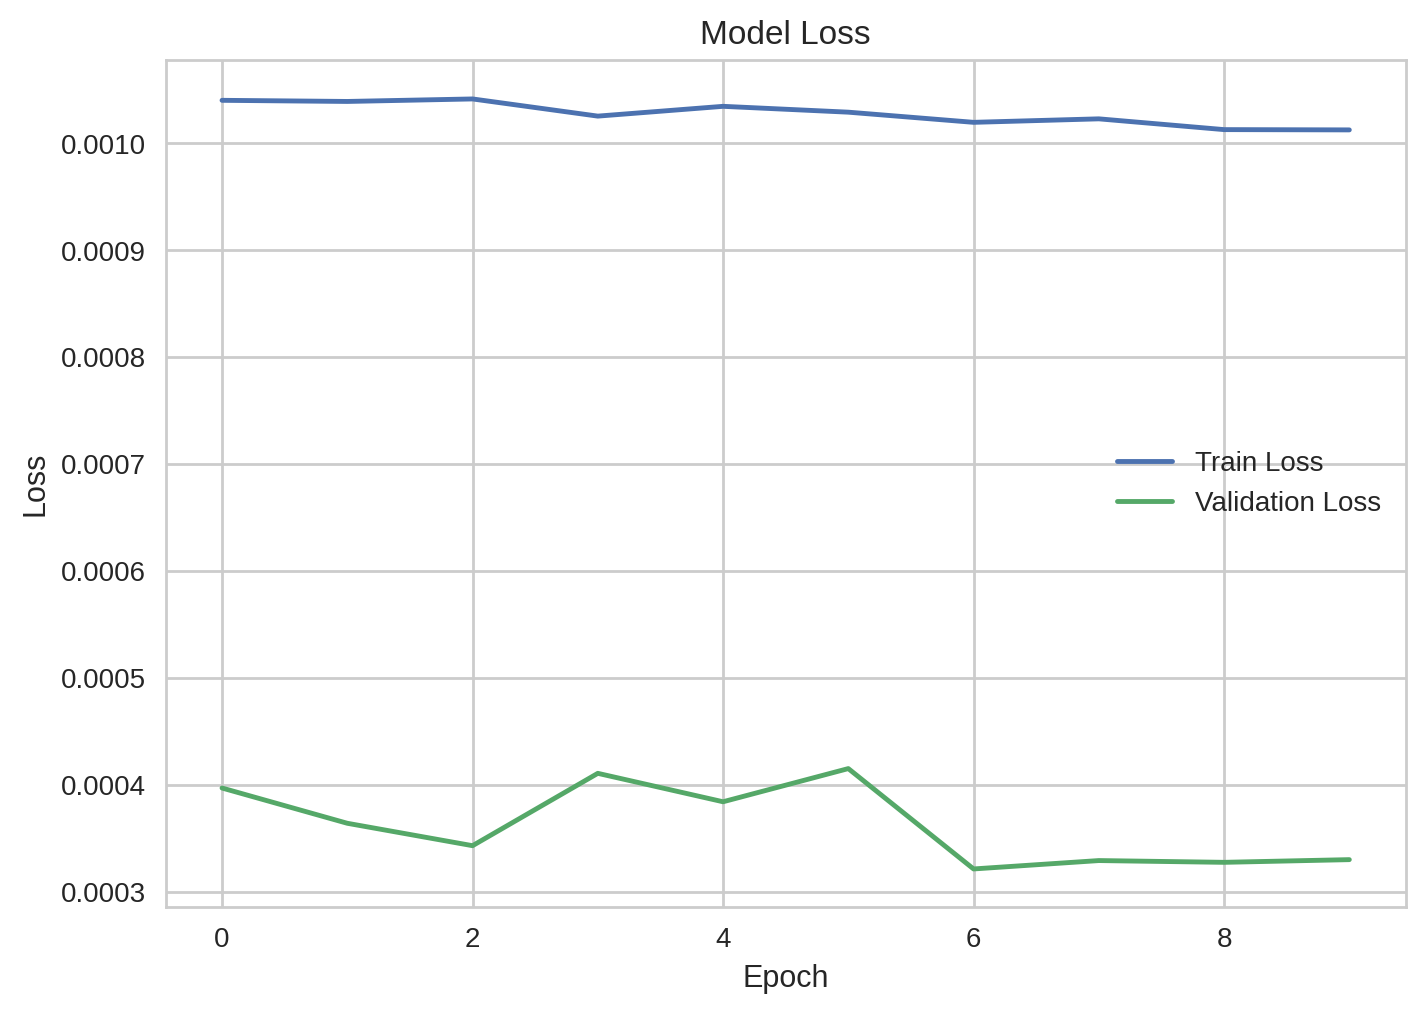

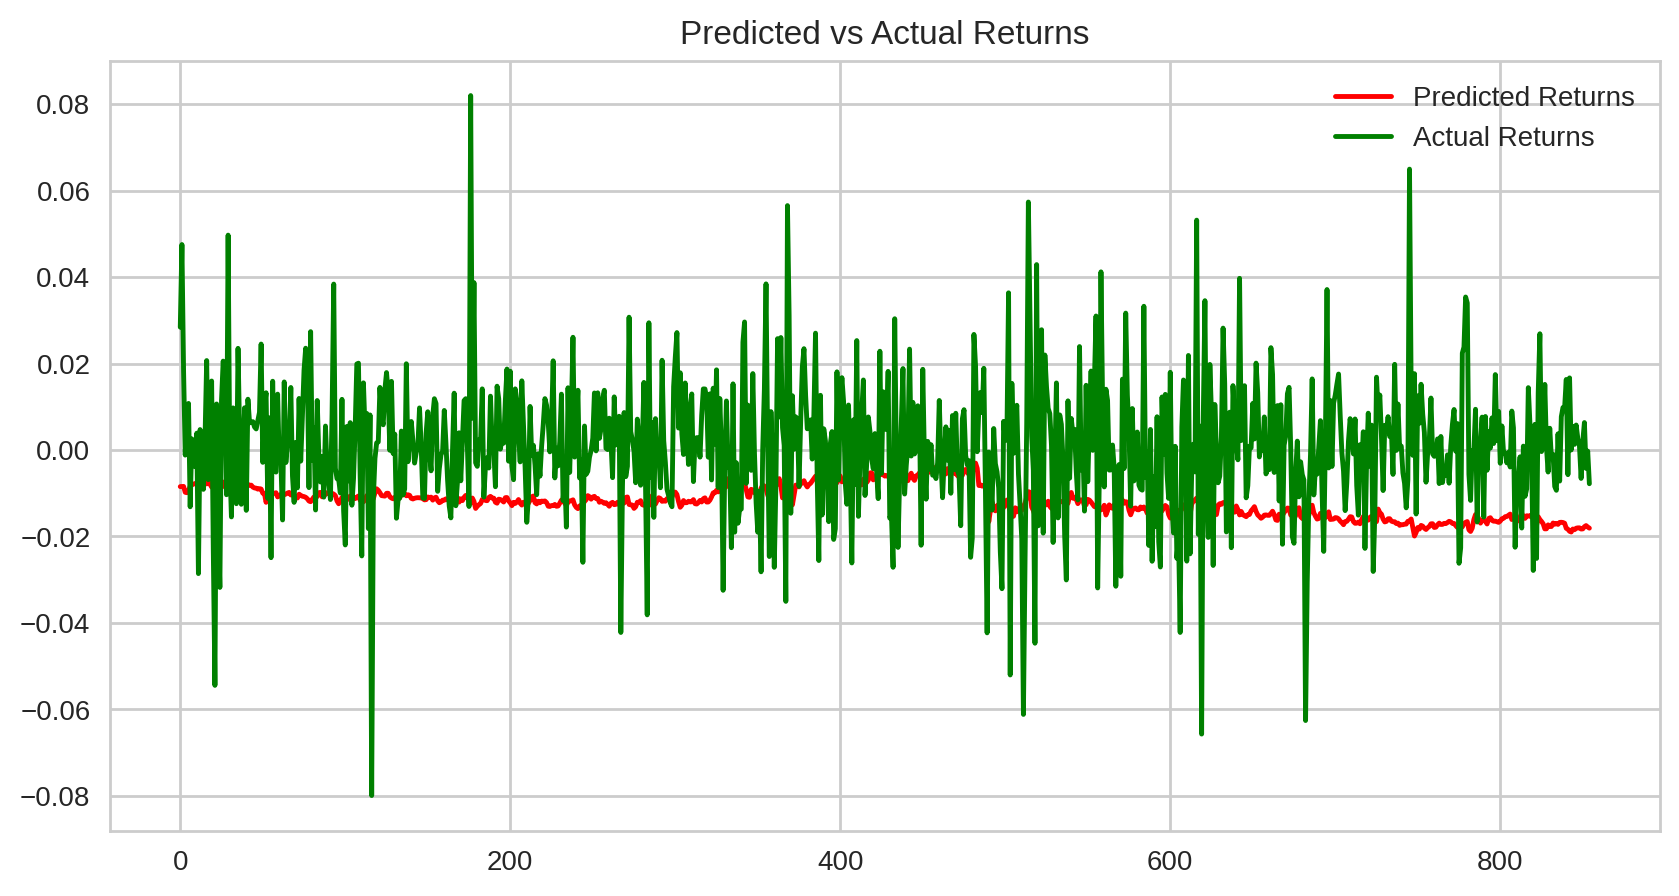

In [ ]:
seq_length = 5  # Number of time steps in the sequence
scaler = MinMaxScaler()

features = ['GOOG','AAPL','SPY']
df_scaled = scaler.fit_transform(data_new[features])
df_scaled = pd.DataFrame(df_scaled, columns=features)
df_scaled = df_scaled[1:]

# Assume 'AAPL_returns' is the target and already scaled if necessary
target = data_new['AAPL'].pct_change(1)
target = target[1:]

# Create sequences
X, y = create_sequences(df_scaled, target, seq_length)

# Split the data into training, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, shuffle=False)  # 0.25 x 0.8 = 0.2

# Train and evaluate the CNN model
n_features = X.shape[2]  # Number of features
model = train_cnn_model(X_train, y_train, X_val, y_val, X_test, y_test, seq_length, n_features)

And that marks the end of our testing and work.
I am choosing the CNN with two features (AAPL Prices and SP returns) for the best model, and the reasoning is explained in the conclusion. For now, let's build the save and load model functions!

## Load and Save final CNN Model

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import os
from tensorflow.keras.models import load_model

modelName = "final_model"
model_path = os.path.join(".", modelName)

def saveModel(model, model_path):
    try:
        os.makedirs(model_path)
    except OSError:
        print("Directory {dir:s} already exists, files will be over-written.".format(dir=model_path))

    # Save JSON config to disk
    json_config = model.to_json()
    with open(os.path.join(model_path, 'config.json'), 'w') as json_file:
        json_file.write(json_config)
    # Save weights to disk
    model.save_weights(os.path.join(model_path, 'weights.h5'))

    print("Model saved in directory {dir:s}; create an archive of this directory and submit with your assignment.".format(dir=model_path))



In [ ]:
def trainModel(data_path, model_path):
  import joblib
  DATA_DIR = "./Data"

  def get_adj_close_data(tickers):
      combined_data = []

      for ticker in tickers:
          file_path = os.path.join(DATA_DIR, 'train', f'{ticker}.csv')
          df = pd.read_csv(file_path)

          # Rename 'Adj Close' and set 'Dt' as index
          df = df.rename(columns={'Adj Close': ticker}).set_index('Dt')
          df.index = pd.to_datetime(df.index)

          # Extract only the renamed 'Adj Close' column
          combined_data.append(df[[ticker]])

      # Concatenate all dataframes along the columns
      final_df = pd.concat(combined_data, axis=1)

      return final_df

  from sklearn.preprocessing import MinMaxScaler
  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
  from sklearn.metrics import mean_squared_error
  from sklearn.model_selection import train_test_split
  import matplotlib.pyplot as plt
  import numpy as np

  def cnn1_val(prices, seq_length):
      # Calculate returns
      prices['SPY_ret'] = prices["SPY"].pct_change(1)
      prices['AAPL_returns'] = prices['AAPL'].pct_change(1)

      # Drop NaN values
      prices = prices[1:]


      def create_sequences(data, seq_length):
        xs, ys = [], []
        for i in range(len(data) - seq_length):
            x = data[['AAPL', 'SPY_ret']].iloc[i:(i + seq_length)].values
            y = data['AAPL_returns'].iloc[i + seq_length]
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)


      # Split the data into training and test sets before normalization and sequence creation
      train_prices = prices[:-200]  # All data except last 200 days for training
      test_prices = prices[-200-seq_length:]  # Last 200 + seq_length days for testing

      # Normalize the training data
      scaler = MinMaxScaler()
      train_scaled = scaler.fit_transform(train_prices[['AAPL', 'SPY_ret']])
      train_prices[['AAPL', 'SPY_ret']] = train_scaled

      # Scale the test data
      test_scaled = scaler.transform(test_prices[['AAPL', 'SPY_ret']])
      test_prices[['AAPL', 'SPY_ret']] = test_scaled

      # Create sequences for training
      X_train, y_train = create_sequences(train_prices, seq_length)
      print(X_train.shape)

      # Split the training data into training and validation sets
      X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

      # Create sequences for testing
      X_test, y_test = create_sequences(test_prices, seq_length)

      # Build the CNN model
      model = Sequential([
          Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, 2)),
          MaxPooling1D(pool_size=2),
          Flatten(),
          Dense(50, activation='relu'),
          Dense(1)
      ])
      model.compile(optimizer='adam', loss='mean_squared_error')

      # Train the model with validation set
      history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

      # Evaluate the model
      predictions = model.predict(X_test)

      plt.plot(predictions, 'r', label='Predicted Returns')
      plt.plot(y_test, 'g', label='Actual Returns')
      plt.title("Predicted vs Actual Returns (CNN1 with Val), seq_length = " + str(seq_length))
      plt.legend()
      plt.show()
      print(model.layers[0].input_shape)
      plt.plot()
      plt.plot(history.history['loss'], label='Train Loss')
      plt.plot(history.history['val_loss'], label='Validation Loss')
      plt.title('Model Loss')
      plt.ylabel('Loss')
      plt.xlabel('Epoch')
      plt.legend(loc='upper right')
      plt.style.use('seaborn-v0_8-whitegrid')
      plt.show()


      rmse = np.sqrt(mean_squared_error(y_test, predictions))
      print('Test RMSE:', rmse)
      return rmse, model



  prices = get_adj_close_data(["AAPL","SPY"])
  rmse, model = cnn1_val(prices, 5)

  modelName = "final_model"
  model_path = os.path.join(".", modelName)
  saveModel(model, model_path)

  # save scaler
  scaler_filename = os.path.join(model_path,'scaler.pkl')
  joblib.dump(min_max_scaler, scaler_filename)


<ipython-input-105-53084a260a03>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_prices[['AAPL', 'SPY_ret']] = train_scaled
<ipython-input-105-53084a260a03>:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prices[['AAPL', 'SPY_ret']] = test_scaled


(4071, 5, 2)
Epoch 1/10
102/102 [==============================] - 1s 5ms/step - loss: 8.4710e-04 - val_loss: 7.8323e-04
Epoch 2/10
102/102 [==============================] - 0s 4ms/step - loss: 7.6907e-04 - val_loss: 7.7761e-04
Epoch 3/10
102/102 [==============================] - 0s 5ms/step - loss: 7.6979e-04 - val_loss: 7.7509e-04
Epoch 4/10
102/102 [==============================] - 1s 6ms/step - loss: 7.6868e-04 - val_loss: 7.6588e-04
Epoch 5/10
102/102 [==============================] - 1s 5ms/step - loss: 7.4950e-04 - val_loss: 7.6658e-04
Epoch 6/10
102/102 [==============================] - 0s 5ms/step - loss: 7.6421e-04 - val_loss: 7.6396e-04
Epoch 7/10
102/102 [==============================] - 0s 5ms/step - loss: 7.6818e-04 - val_loss: 8.3265e-04
Epoch 8/10
102/102 [==============================] - 1s 5ms/step - loss: 7.5819e-04 - val_loss: 7.7151e-04
Epoch 9/10
102/102 [==============================] - 0s 5ms/step - loss: 7.5149e-04 - val_loss: 7.8837e-04
Epoch 10/10
7/7

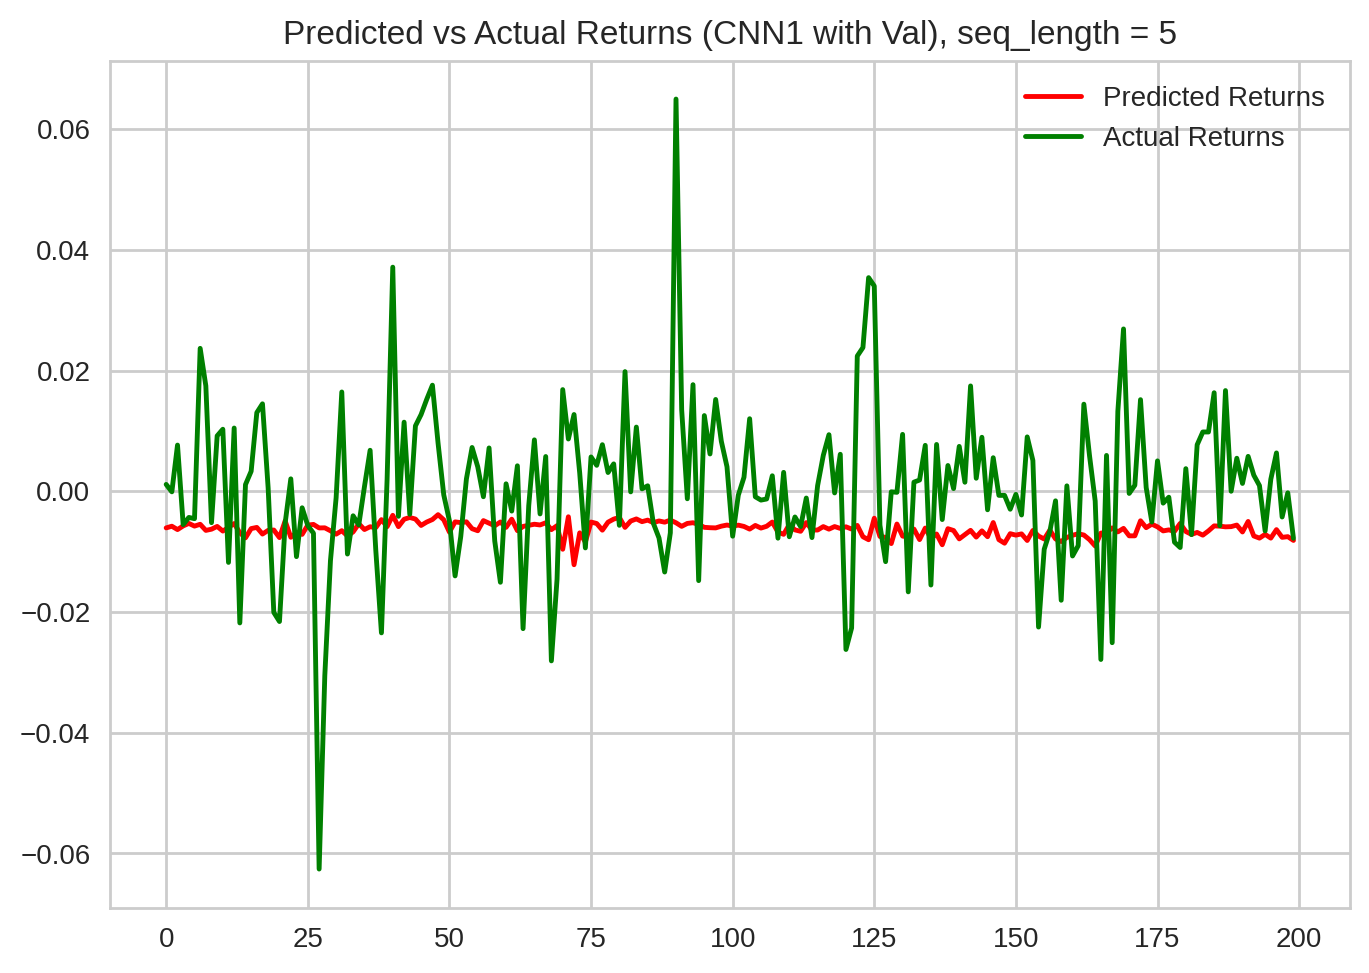

(None, 5, 2)


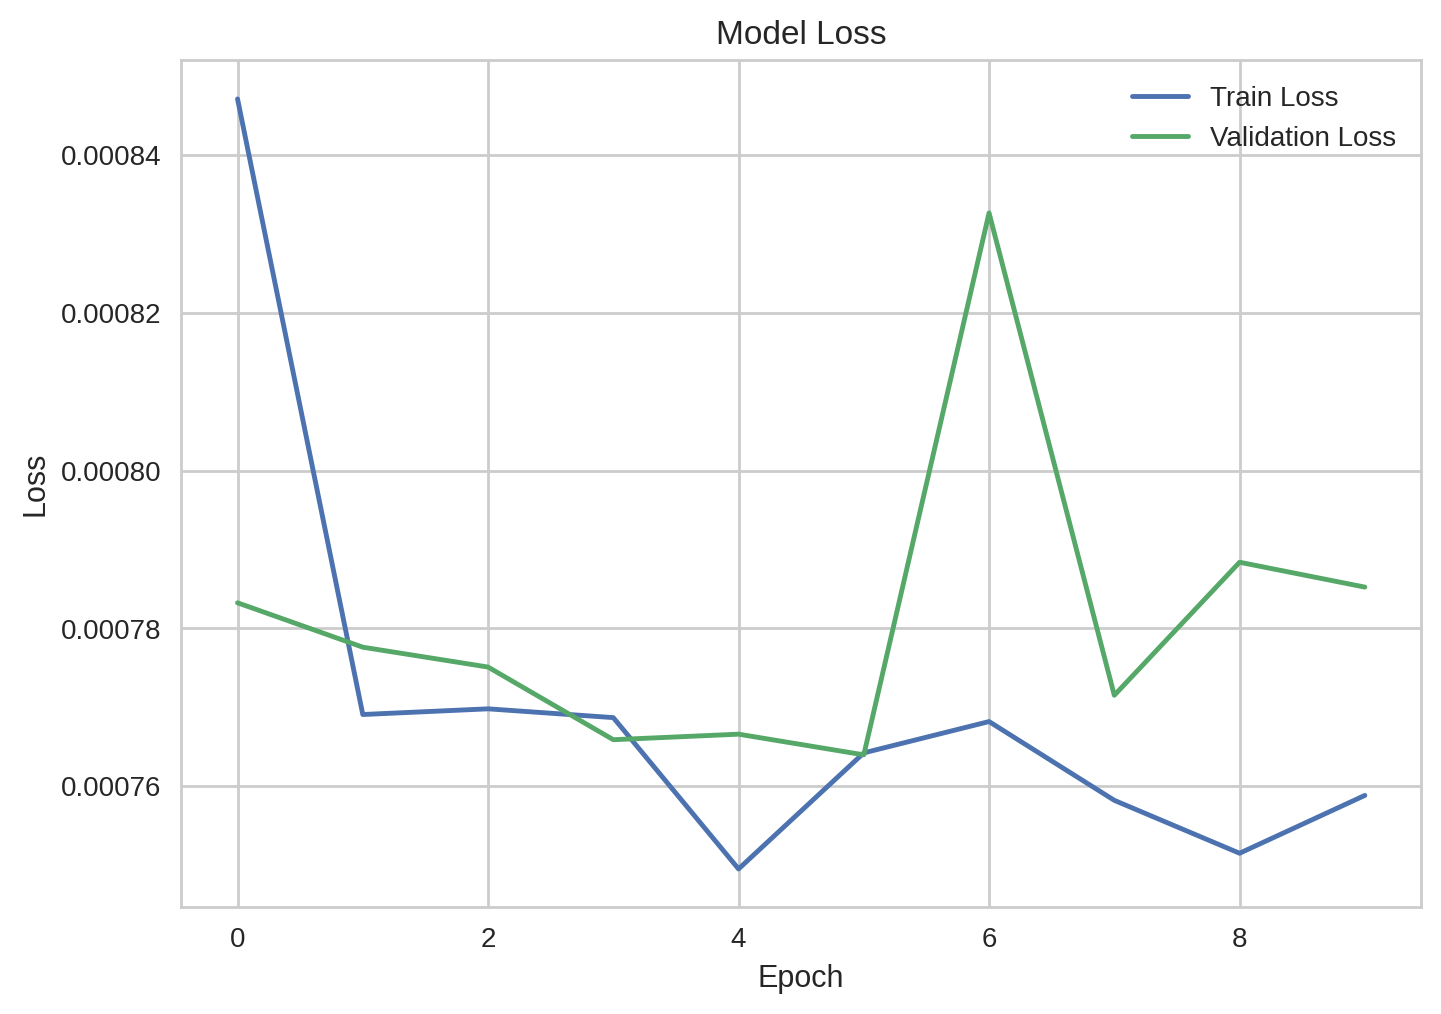

Test RMSE: 0.014627741818911669
Directory ./final_model already exists, files will be over-written.
Model saved in directory ./final_model; create an archive of this directory and submit with your assignment.


In [ ]:
trainModel('./Data/train/','model_save')

# **MyModel**

In [18]:
def loadModel(model_path):
    # Reload the model from the 2 files we saved
    with open(os.path.join(model_path, 'config.json')) as json_file:
        json_config = json_file.read()
    model = tf.keras.models.model_from_json(json_config)
    model.load_weights(os.path.join(model_path, 'weights.h5'))

    return model

def MyModel(test_dir, model_path):
    # YOU MAY NOT change model after this statement !
    model = loadModel(model_path)
    DATA_DIR = "./Data"
    seq_length = 5

    # It should run model to create an array of predictions; we initialize it to the empty array for convenience
    predictions = []


    from sklearn.preprocessing import MinMaxScaler
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import train_test_split
    import matplotlib.pyplot as plt
    import numpy as np

    # We need to match your array of predictions with the examples you are predicting
    # The array below (ids) should have a one-to-one correspondence and identify the example your are predicting
    # For Bankruptcy: the Id column
    # For Stock prediction: the date on which you are making a prediction
    ids = []

    # YOUR CODE GOES HERE

    # I have written a small funcrtion to ensure safe data reading.
    def get_adj_close_data(tickers):
      combined_data = []

      for ticker in tickers:
          file_path = os.path.join(DATA_DIR, 'train', f'{ticker}.csv')
          df = pd.read_csv(file_path)

          # Rename 'Adj Close' and set 'Dt' as index
          df = df.rename(columns={'Adj Close': ticker}).set_index('Dt')
          df.index = pd.to_datetime(df.index)

          # Extract only the renamed 'Adj Close' column
          combined_data.append(df[[ticker]])

      # Concatenate all dataframes along the columns
      final_df = pd.concat(combined_data, axis=1)

      return final_df
    prices = get_adj_close_data(["AAPL","SPY"])
    # Calculate returns
    prices['SPY_ret'] = prices["SPY"].pct_change()
    prices['AAPL_returns'] = prices['AAPL'].pct_change()

    # Drop NaN values
    prices = prices[1:]


    def create_sequences(data, seq_length):
      xs, ys = [], []
      for i in range(len(data) - seq_length):
          x = data[['AAPL', 'SPY_ret']].iloc[i:(i + seq_length)].values
          y = data['AAPL_returns'].iloc[i + seq_length]
          xs.append(x)
          ys.append(y)
      return np.array(xs), np.array(ys)


    # Split the data into training and test sets before normalization and sequence creation
    train_prices = prices[:-200]  # All data except last 200 days for training
    test_prices = prices[-200-seq_length:]  # Last 200 + seq_length days for testing

    # Normalize the training data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_prices[['AAPL', 'SPY_ret']])
    train_prices[['AAPL', 'SPY_ret']] = train_scaled

    # Scale the test data
    test_scaled = scaler.transform(test_prices[['AAPL', 'SPY_ret']])
    test_prices[['AAPL', 'SPY_ret']] = test_scaled

    # Create sequences for training
    X_train, y_train = create_sequences(train_prices, seq_length)
    # print(X_train.shape)

    # Split the training data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    # print("Working check 1")
    # Create sequences for testing
    X_test, y_test = create_sequences(test_prices, seq_length)
    # print("WOrking check 2")
    # print(X_test)
    predictions = model.predict(X_test)
    ids = prices.index[-200:]


    return predictions, ids



In [ ]:
preds,ids = MyModel('./Data/train/','final_model')

<ipython-input-107-765b96fe0fbb>:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_prices[['AAPL', 'SPY_ret']] = train_scaled
<ipython-input-107-765b96fe0fbb>:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prices[['AAPL', 'SPY_ret']] = test_scaled


7/7 [==============================] - 0s 3ms/step


In [19]:
import os
model_path = 'final_model'
holdout_dir = os.path.join(".", "Data", "sample")
predicts = MyModel(holdout_dir, model_path)

<ipython-input-18-b3ecc9dbd54c>:81: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_prices[['AAPL', 'SPY_ret']] = train_scaled
<ipython-input-18-b3ecc9dbd54c>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_prices[['AAPL', 'SPY_ret']] = test_scaled


7/7 [==============================] - 0s 3ms/step


# **Conclusion**


### Summary:


#### Model Summaries:
1. **Baseline Models**:
    - **Baseline 1**: Utilized simple return prediction method of rolling average.
    - **Baseline 2**: Deployed poly regression.

2. **Neural Network Models**:
    - **LSTM Model**: Applied LSTM using only AAPL's price for predicting returns.
    - **CNN Models**:
        - With validation dataset: Used AAPL Adjusted Close and S&P Returns as features.
        - **CNN with Multiple Features and Lasso Regression**: Selected features through Lasso, possibly leading to a more complex model.
        - **CNN with GOOG prices only**: A more simplistic model focusing on a single feature's predictive power.
        - **CNN with AAPL and GOOG prices**: An intermediate complexity model using two related stock prices.
        - **CNN with AAPL, SPY, GOOG prices**: A complex model that leverages multiple market indicators.
    

#### Analysis of Results:

The CNN model with a validation dataset may not have the lowest RMSE compared to the model using only GOOG prices, but it exhibits a better fit in terms of the shape of the predicted returns against the actual returns. This could indicate that despite the CNN model with validation having a higher RMSE, it may be capturing the dynamics and volatility of the market more accurately.

- **Shape vs. RMSE**: A model that fits the overall trend and volatility patterns of the returns, even with a slightly higher RMSE, can be more desirable than a model with a lower RMSE that fails to capture these dynamics.
- **Consistency of Prediction**: If the GOOG price model is consistently off by a similar margin, it may not be adjusting well to market changes, whereas the CNN model with validation shows adaptability, suggesting it could perform better on out-of-sample data or in changing market conditions.
- **Overfitting Concerns**: The model with the lowest RMSE might be overfitting to the noise rather than the signal if it lacks validation. The presence of a validation dataset in the training process helps mitigate this risk by providing a more robust assessment of model performance.

### Table of Results :

| Model                         | Features Used              | Train RMSE | Test RMSE | Overfitting | Shape Fit |
|-------------------------------|----------------------------|------------|-----------|-------------|-----------|
| Baseline 1                    | None (Rolling Average)               | 0.027        | 0.012      | N/A          | Average      |
| Baseline 2 (Linear Reg.)      | AAPL Prices                | N/A        | 0.013       | No          | Poor  |
| LSTM                          | AAPL Prices                | 0.0004   | 0.02  | Possible    | Very Poor (Almost flat)      |
| CNN (With Val)                | AAPL & SPY                 | Very Less!   | 0.014  | Less Likely (Based on validation plots)| Very Good |
| CNN with Lasso Selection(Only GOOG)               | GOOG Prices                | 0.001        | 0.02  | Less Likely    | Inconsistent |
| CNN with Lasso Selection (AAPL & GOOG)             | AAPL & GOOG Prices         | 0.001   | 0.05  | Less Likely | Average      |
| CNN (AAPL, SPY, GOOG)         | AAPL, SPY, & GOOG Prices   | 0.001       | 0.019  | Less Likely      | Good      |




### Comprehensive Analysis and Conclusion

#### Overview of Efforts:

The journey of model development commenced with a thorough Exploratory Data Analysis (EDA), which laid a solid foundation for informed model building. The EDA involved:

- Plotting the movements and returns of AAPL prices.
- Comparing SPY returns with AAPL returns to understand market influences.
- Analyzing a heatmap of all considered stocks to identify the most relevant features.
- Conducting an Augmented Dickey-Fuller (ADF) Test, which indicated non-stationarity in the time series data, a crucial factor in model selection and preprocessing.

#### Model Development and Analysis:

Following EDA, various models were developed, ranging from simple baselines to more complex neural networks. Each model's performance was evaluated based on training and test RMSE, overfitting potential, and the shape fit quality.

1. **Baseline Models** served as initial benchmarks, with the rolling average model providing a simplistic yet somewhat effective prediction, and polynomial regression indicating the need for more sophisticated methods.

2. **Advanced Neural Network Models**:
    - The **LSTM model**, while achieving low train RMSE, showed possible overfitting and a very poor shape fit, suggesting its ineffectiveness in capturing the true market dynamics.
    - **CNN Models** demonstrated more promise:
        - The **CNN with Validation** emerged as the most effective, balancing complexity with accuracy and showing a good fit in terms of capturing market trends and volatility.
        - Other CNN variants, while exploring different feature sets and complexities, provided insights into the importance of feature selection and model architecture in predicting stock prices.

#### Final Model Selection:

The **CNN Model with Validation**, leveraging AAPL and SPY features, was the chosen model. Its strengths were evident in its low unspecified Train RMSE, Test RMSE of 0.014, less likelihood of overfitting (as indicated by validation plots), and an excellent shape fit. This model not only demonstrated high accuracy but also effectively captured the market's underlying patterns and trends, making it a robust tool for predicting future stock movements.

#### Conclusion:

The journey from initial EDA to final model selection underscores the importance of a comprehensive approach in financial time series forecasting. The chosen CNN model stands out for its ability to balance complexity with predictability, effectively capturing market dynamics without overfitting. This project highlights the critical role of methodical data analysis, appropriate feature selection, and careful model evaluation in developing reliable predictive models in the volatile realm of stock prices. The success of the CNN model with validation reaffirms the potential of advanced machine learning techniques in financial market analysis and prediction.

In [ ]:
print("Done! Thank you for a wonderful semester, Shiyi and Prof Perry!")

Done! Thank you for a wonderful semester, Shiyi and Prof Perry!
